# Prediction of Wind Turbine Power Generation using SCADA Data

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn numpy scipy statsmodels

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_regression, \
    r_regression, mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import pickle

In [2]:
pd.set_option('display.max_rows', 100)

## I. Introduction
### 1. Domain-specific area and objectives of the project
In this project, we are researching the relationship between Wind Turbine Power Generation and the SCADA parameters of the turbine, such as temperature, pressure, voltage, and torque of various turbine components and technical fluids. SCADA, which stands for Supervisory Control And Data Acquisition, is an electronic system that collects monitoring data from different devices, stores it, and displays it on a GUI for operators.

Many interconnected domain-specific areas are included in the process of designing and maintaining wind turbines, at least it is closely related to:
1. Mechanical, electrical, and aerodynamic engineering. In the context of wind turbines, those domains help to build highly efficient and safe turbines with optimal balance between resources spent, wind power, and resulting electrical power.
2. Energy industry. In the context of wind turbines, it is about how to effectively pass electrical energy to the consumers, where and why choose to build wind turbines.
3. Ecology. It helps to embed wind turbines in the ecosphere in a proper way. Knowing the wind turbine features empowers ecology with more correct and deeper tools.

Contributions of this project may be:
1. Detection of a wind turbine failure when the resulting electrical power is lower than predicted by the model built.
2. Using the model as a fallback system for measuring the resulting power when something is wrong with the main power measurement tools.
3. Detection of mistakes in a wind turbine design when we have different values for the predicted power and the power calculated mathematically.

Objectives are the following:
1. Find an appropriate dataset.
2. Analyze the dataset visually and statistically.
3. Extract meaningful features.
4. Build a Linear Regression ML-model that predicts the resulting power based on the extracted features.
5. Evaluate the model.

### 2. Dataset
The dataset helpful for the project purpose is found on the Kaggle official website: Wind Turbine Power (kW) Generation Data - https://www.kaggle.com/datasets/psycon/wind-turbine-energy-kw-generation-data.
It has about 150.000 records with the real-time SCADA data and corresponding power generation amount on a 10-minute basis. SCADA data are given for the period (01.01.2019 – 14.12.2021), which overlaps the period for the power generation amount data (01.01.2019 - 14.08.2021).

The dataset has 3 files:
1. **features.csv** - 77 columns: **Timestamp** (in the format YYYY-MM-DD hh:mm:ss) and 76 SCADA parameters. All the parameters are decimal numbers.

In [2]:
pd.read_csv('data/raw/features.csv')

Timestamp  Gearbox_T1_High_Speed_Shaft_Temperature  \
0       2019-01-01 00:00:00                                57.000000   
1       2019-01-01 00:10:00                                57.693333   
2       2019-01-01 00:20:00                                59.000000   
3       2019-01-01 00:30:00                                59.881668   
4       2019-01-01 00:40:00                                61.290001   
...                     ...                                      ...   
154257  2021-12-14 23:10:00                                65.811668   
154258  2021-12-14 23:20:00                                68.586670   
154259  2021-12-14 23:30:00                                63.746666   
154260  2021-12-14 23:40:00                                66.643333   
154261  2021-12-14 23:50:00                                65.593330   

        Gearbox_T3_High_Speed_Shaft_Temperature  \
0                                     59.000000   
1                                     59.485001   
2                                     60.756668   
3                                     61.563332   
4                                     62.586666   
...                                         ...   
154257                                      NaN   
154258                                      NaN   
154259                                      NaN   
154260                                      NaN   
154261                                      NaN   

        Gearbox_T1_Intermediate_Speed_Shaft_Temperature  \
0                                             52.000000   
1                                             52.450001   
2                                             53.536667   
3                                             54.413334   
4                                             55.485001   
...                                                 ...   
154257                                        59.945000   
154258                                        62.084999   
154259                                        59.965000   
154260                                        60.678333   
154261                                        60.738335   

        Temperature Gearbox Bearing Hollow Shaft  Tower Acceleration Normal  \
0                                      56.158333                  47.053776   
1                                      57.000000                  64.969742   
2                                      57.775002                  51.149670   
3                                      58.683334                  58.740929   
4                                      59.623333                  53.264774   
...                                          ...                        ...   
154257                                 62.808334                 225.038239   
154258                                 65.413330                 229.905838   
154259                                 64.051666                 223.352631   
154260                                 63.421665                 227.704514   
154261                                 64.731667                 223.235413   

        Gearbox_Oil-2_Temperature  Tower Acceleration Lateral  \
0                       57.000000                   18.890772   
1                       57.413334                   28.560265   
2                       58.728333                   34.228813   
3                       59.518333                   35.593220   
4                       60.665001                   38.552731   
...                           ...                         ...   
154257                  65.300003                  109.889709   
154258                  67.871666                  106.016670   
154259                  64.461670                  111.690208   
154260                  66.081665                  119.716499   
154261                  65.891670                  103.372475   

        Temperature Bearing_A  Temperature Trafo-3  ...  \
0                   35.000000            4

2. **feature_units.csv** - the list of the SCADA parameters from the **features.csv** with their units. It is not required for this project but allows us to better undestand the nature of the features. Can be used later for deeper analysis.

In [26]:
pd.read_csv('data/raw/feature_units.csv')

Column   Unit
0                                         Timestamp     ()
1           Gearbox_T1_High_Speed_Shaft_Temperature   (°C)
2           Gearbox_T3_High_Speed_Shaft_Temperature   (°C)
3   Gearbox_T1_Intermediate_Speed_Shaft_Temperature   (°C)
4          Temperature Gearbox Bearing Hollow Shaft   (°C)
..                                              ...    ...
72                               Moment Q Direction  (kNm)
73                               Moment Q Filltered  (kNm)
74                           Proxy Sensor_Degree-45   (mm)
75                                    Turbine State    ( )
76                          Proxy Sensor_Degree-315   (mm)

[77 rows x 2 columns]

3. power.csv - 2 columns: **Timestamp** (in the format YYYY-MM-DD hh:mm:ss) and the resulting power amount in kW. The resulting power is a decimal number.

In [28]:
pd.read_csv('data/raw/power.csv')

Timestamp    Power(kW)
0       2019-01-01 00:00:00   705.876648
1       2019-01-01 00:10:00   884.711670
2       2019-01-01 00:20:00   982.875000
3       2019-01-01 00:30:00  1115.943359
4       2019-01-01 00:40:00  1263.841675
...                     ...          ...
136725  2021-08-14 23:10:00  2757.728271
136726  2021-08-14 23:20:00  2758.323242
136727  2021-08-14 23:30:00  2759.243408
136728  2021-08-14 23:40:00  2761.261719
136729  2021-08-14 23:50:00  2758.593262

[136730 rows x 2 columns]

The dataset looks to suit the purpose for the following reasons:
1. Contains data for supervised learning.
2. Has enough amount data for building a reliable ML-model.
3. Has a lot of features and we can find which of them are important and discard others.
4. There are no many other datasets with the similar data over the public Internet.
5. Hypothetically Linear Regression approach can be fine here as on the scatter plots below we can see that for some features, there is something similar to the linear relationship between a feature (or its polynomial version) and the resulting power.

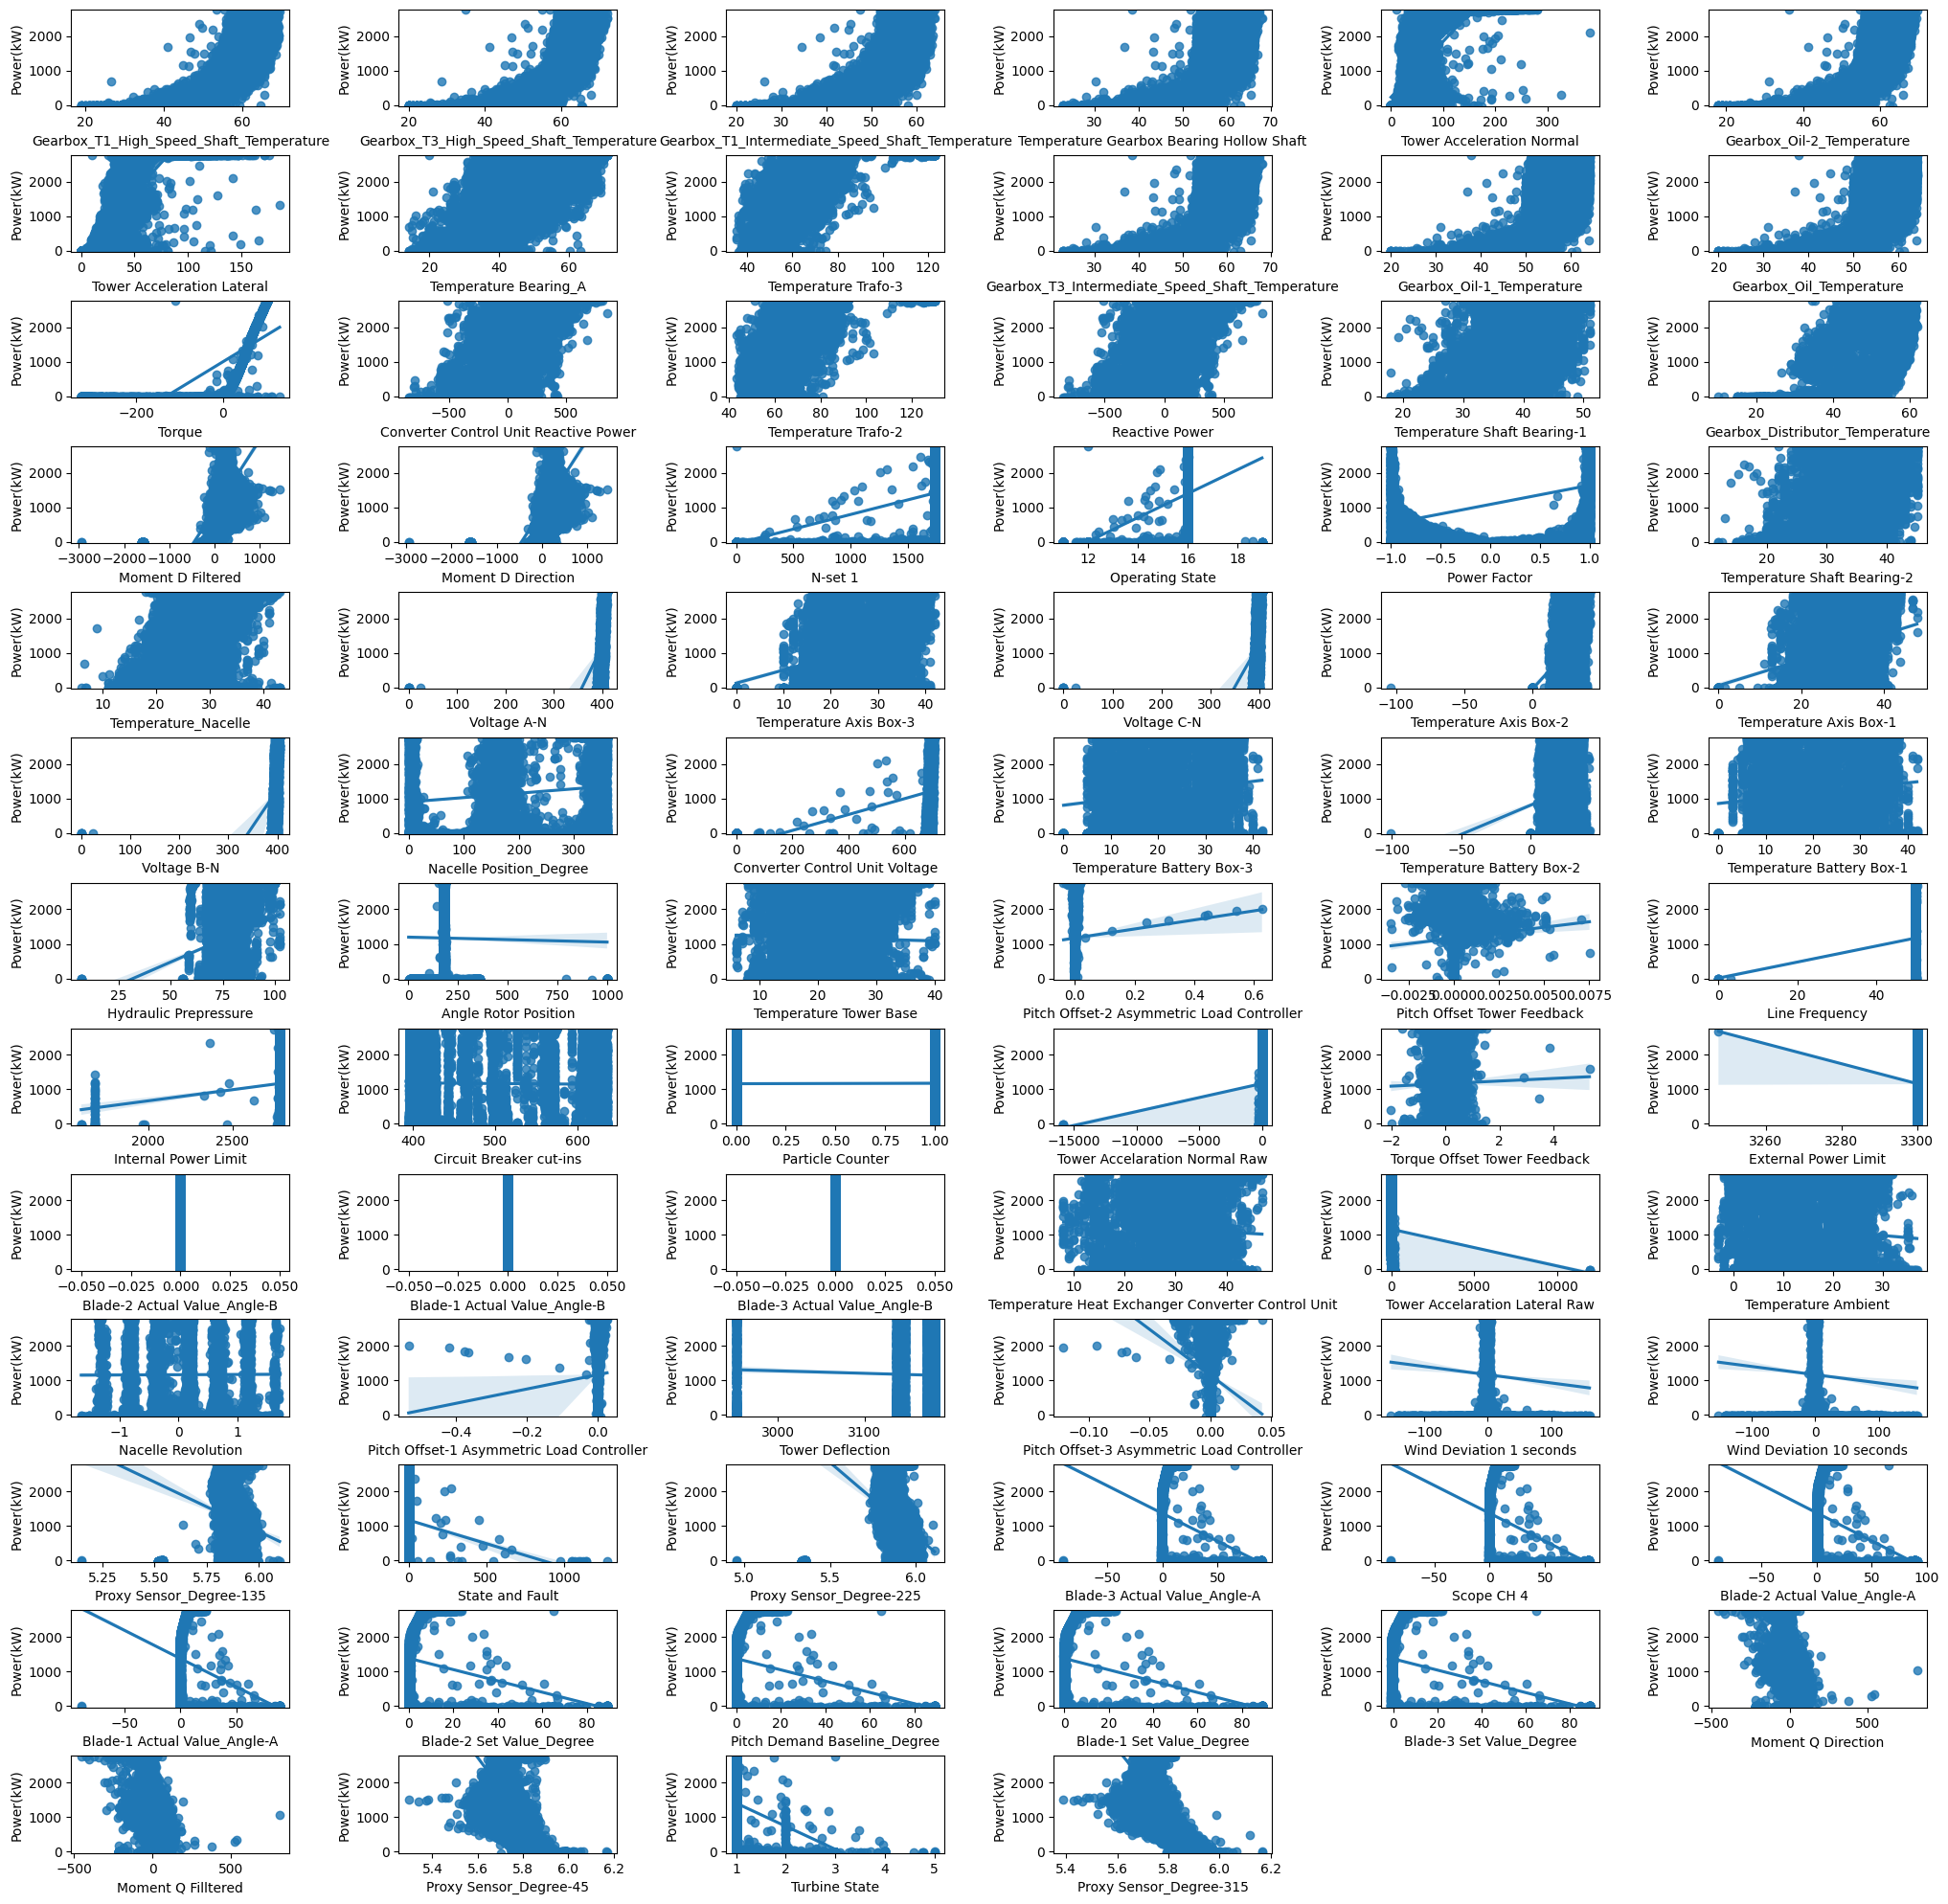

In [7]:
# build the dataset and apply cleaning a bit
features_df = pd.read_csv('data/raw/features.csv')
power_df = pd.read_csv('data/raw/power.csv')
result_df = features_df.merge(power_df, on = "Timestamp")
result_df = result_df[
    result_df.loc[:, result_df.columns != "Timestamp"] < 99999
].drop("Timestamp", axis=1).dropna()

# find bounds for Y-axis
min_power = result_df["Power(kW)"].min()
max_power = result_df["Power(kW)"].max()

# init plot representation
fig, axes = plt.subplots(13, 6, figsize = (25, 25))
axes = axes.ravel()

# build a scatter plot for each feature
for (i, column) in enumerate(
    column for column in result_df \
        if column not in ["Timestamp", "Power(kW)"]
):
    sns.regplot(x = column, y = "Power(kW)", data = result_df, ax = axes[i])
    axes[i].set(ylim=(min_power, max_power))

# delete empty subplots
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

# aligh subplots
plt.subplots_adjust(wspace = 0.5, hspace=0.5)

# show resulting plot
plt.show()

## II. Implementation
### 3. Convert/store the dataset locally and preprocess the data. 
We need 2 files from the dataset described above: **features.csv** and **power.csv**. They both have CSV format as described in the Dataset section. 
The following preprocessing steps are planned:
1. Merge rows from the files by **Timestamp**. That is how we map the features and the target variables between each other for later usage in supervised learning and evaluation of an ML-model.
2. Validate the data format of the columns, reformat where needed, and cast to float64. CSV keeps all the data in a text format, and we need to ensure all the features and target variables are recognized as float64.
3. Check for missing values, choose and apply some imputation techniques to transform the data to the format acceptable for ML.

As the dataset contains no categorical or ordinal types, thus we do not need to apply any text cleaning and preprocessing techniques.

In [180]:
# merge and describe the dataset to see some statistical
# summary for each of the columns and undestand how we can clean the data
features_df = pd.read_csv('data/raw/features.csv')
power_df = pd.read_csv('data/raw/power.csv')
result_df = features_df.merge(power_df, on = "Timestamp")
print(result_df.shape)
result_df.describe().T

(136730, 78)


count         mean  \
Gearbox_T1_High_Speed_Shaft_Temperature            132779.0   896.733880   
Gearbox_T3_High_Speed_Shaft_Temperature            132438.0   887.755432   
Gearbox_T1_Intermediate_Speed_Shaft_Temperature    133066.0   994.913733   
Temperature Gearbox Bearing Hollow Shaft           133466.0   958.506611   
Tower Acceleration Normal                          132709.0   919.407899   
Gearbox_Oil-2_Temperature                          132175.0   918.942881   
Tower Acceleration Lateral                         132885.0   957.228994   
Temperature Bearing_A                              133084.0   878.770355   
Temperature Trafo-3                                132559.0   923.752455   
Gearbox_T3_Intermediate_Speed_Shaft_Temperature    132986.0   894.884391   
Gearbox_Oil-1_Temperature                          132910.0   935.787892   
Gearbox_Oil_Temperature                            132150.0   850.958075   
Torque                                             133101.0   953.577528   
Converter Control Unit Reactive Power              132824.0   853.212949   
Temperature Trafo-2                                132842.0   931.327331   
Reactive Power                                     132845.0   853.111766   
Temperature Shaft Bearing-1                        133034.0   863.539909   
Gearbox_Distributor_Temperature                    133633.0   892.901387   
Moment D Filtered                                  132615.0  1002.794001   
Moment D Direction                                 132476.0   990.123688   
N-set 1                                            132469.0  2224.239158   
Operating State                                    133612.0   842.212730   
Power Factor                                       132238.0   898.550853   
Temperature Shaft Bearing-2                        133210.0   908.943961   
Temperature_Nacelle                                132494.0   862.706638   
Voltage A-N                                        132635.0  1279.245737   
Temperature Axis Box-3                             133707.0   926.046416   
Voltage C-N                                        133112.0  1227.436285   
Temperature Axis Box-2                             132647.0   939.776347   
Temperature Axis Box-1                             132884.0   951.326172   
Voltage B-N                                        133307.0  1273.009982   
Nacelle Position_Degree                            132586.0  1107.108802   
Converter Control Unit Voltage                     132697.0  1538.141244   
Temperature Battery Box-3                          133149.0   872.086296   
Temperature Battery Box-2                          132635.0   906.561823   
Temperature Battery Box-1                          133416.0   924.278394   
Hydraulic Prepressure                              132865.0   957.260730   
Angle Rotor Position                               132360.0  1086.069130   
Temperature Tower Base                             133301.0   851.910860   
Pitch Offset-2 Asymmetric Load Controller          132799.0   863.704397   
Pitch Offset Tower Feedback                        132261.0   870.240341   
Line Frequency                                     133075.0   978.291017   
Internal Power Limit                               132981.0  3626.520126   
Circuit Breaker cut-ins                            133345.0  1449.733795   
Particle Counter                                   132682.0   908.434882   
Tower Accelaration Normal Raw                      132277.0   814.309936   
Torque Offset Tower Feedback                       132906.0   813.346603   
External Power Limit                               132655.0  4093.690508   
Blade-2 Actual Value_Angle-B                       132780.0   858.561025   
Blade-1 Actual Value_Angle-B                       132650.0   880.502636   
Blade-3 Actual Value_Angle-B                       132732.0   851.355678   
Temperature Heat Exchanger Converter Control Unit  132201.0   846.983618   
Tower Accelaration Lateral

At least we can see the following issues in the dataset:
1. **count** is different for different columns and is less than the total number of records for almost all the columns. It means we have NaN values for some samples and should handle that somehow.
2. -273 is the number from Physics. It means the Absolute zero of temperature. It looks like it is used as a placeholder for Temperature columns.
3. 99999 is presented in all the columns and lies far from the corresponding mean and median. It looks like it is also a placeholder for all the columns.

Let's try to fix all of that using KNNImputer. KNNImputer is chosen because we assume that the missing values are caused by short outages in the SCADA monitoring channels, and the mean of the values from the same column from the closest samples (by Timestamp) may provide the balance between simplicity of implementation and accuracy of filling missing values.

But first we are splitting the dataset on the training and the testing parts. The dataset is splitted by time because that is a Timeline dataset. We are going to fit all the sklearn estimators/transformers now and further only with the training dataset.

In [21]:
# cast Timestamp string to the np.datetime64
result_df['Timestamp'] = pd.to_datetime(result_df['Timestamp'])

# split to train and test datasets
# approximately 80%
train_df = result_df[result_df['Timestamp'] < '2021-03-01 00:00:00']
# approximately 20%
test_df = result_df[result_df['Timestamp'] >= '2021-03-01 00:00:00']

# cast timestammp to int for comparing time distance in KNNImputer
train_df.loc[:,'Timestamp'] = train_df['Timestamp'].astype(int)
test_df.loc[:,'Timestamp'] = test_df['Timestamp'].astype(int)
# replace all the placeholders with a single value for 
# unification of processing missing values
train_df = train_df.replace([-273, 99999], np.nan)
test_df = test_df.replace([-273, 99999], np.nan)

# init KNNImputer
timestamp_column_index = result_df.columns.get_loc("Timestamp")
knnImputer = KNNImputer(
    missing_values = np.nan,
    n_neighbors = 2,
    # override distance function
    metric = lambda X, Y, **kwds: \
        abs(X[timestamp_column_index] - Y[timestamp_column_index])
)
# fit KNN imputer on the train data
knnImputer.fit(train_df)

KNNImputer(metric=<function <lambda> at 0x7fbd15a8a430>, n_neighbors=2)

Transform the train and the test datasets.

In [ ]:
train_df[:] = knnImputer.transform(train_df)
test_df[:] = knnImputer.transform(test_df)

Now let's remove the Timestamp column which is not needed anymore and ensure other columns have float64 datatype.

In [33]:
# drop TImestamp column
train_df = train_df.drop(columns = ['Timestamp'])
test_df = test_df.drop(columns = ['Timestamp'])

# print number of columns with a type other than float64
print(train_df.loc[:,train_df.dtypes != 'float64'].shape[1])
print(test_df.loc[:,test_df.dtypes != 'float64'].shape[1])

0
0


Now all the issues mentioned are resolved and we have cleaned train and test datasets.

In [34]:
train_df.to_pickle('data/preprocessed/train.pickle')
test_df.to_pickle('data/preprocessed/test.pickle')

As one more cleaning technique, we could analyze outliers and get rid of them, but that requires knowing the distribution for each column and is coverred in the Feature Engineering section after we visualize distribution in the Visualization section.

### 4. Identify key series of the dataset and provide statistical summary of the data.
The features provided in the dataset are deeply domain-specific, and without knowing the subject area it is difficult to highlight the key series in the dataset. We can dive deeper into the subject area and use the file **feature_units.csv** to better understand the meaning of the features, but that is out of scope of this project. Our plan is to use ML and statistical methods to extract key features. That part is covered in section 6 about building an ML-model.

In this section we will try to statistically describe all the series available. That analysis may help to optimize the feature engineering process later.

For each column we will find out:
1. Min - to understand a lower bound.
2. Max - to understand an upper bound.
2. Mean - as a measure of central tendency.
4. Quartiles (25%, 50% (median), and 75%) - to understand spread and how the median is correlated to the mean to make high-level outcomes about outliers.
3. Standard deviation - to understand how much values in a series are different from each other.
4. Skewness - to understand a symmetry of distribution compared to the normal distribution.
5. Kurtosis - to understand how much tails of a distribution differ from the center of the distribution, see its "sharpness".
6. Type of distribution - leptokurtic, mesokurtic, or platykurtic. The table below contains only a very rough estimate. 

Mode does not make much sense for most of the columns as the columns have arbitrary decimal values in some range.

Skewness and Kurtosis may allow us to make some assumption about distribution and how close it is to the normal distribution. A more detailed view on the distribution for each series is provided in the next section about visualization.

In [238]:
train_df = pd.read_pickle('data/preprocessed/train.pickle')
statistics_df = train_df.describe().T
statistics_df['variance'] = train_df.var()
statistics_df['number_of_unique'] = train_df.nunique()
statistics_df['skewness'] = train_df.skew()
statistics_df['kurtosis'] = train_df.kurtosis()
statistics_df['distribution'] = statistics_df['kurtosis'].map(
    lambda kurtosis: \
        'leptokurtic' if kurtosis > 0.1 \
        else 'platykurtic' if kurtosis < - 0.1 \
        else 'mesokurtic'
)
statistics_df

count         mean  \
Gearbox_T1_High_Speed_Shaft_Temperature            112782.0    53.081246   
Gearbox_T3_High_Speed_Shaft_Temperature            112782.0    54.941556   
Gearbox_T1_Intermediate_Speed_Shaft_Temperature    112782.0    49.459988   
Temperature Gearbox Bearing Hollow Shaft           112782.0    53.414160   
Tower Acceleration Normal                          112782.0    61.475645   
Gearbox_Oil-2_Temperature                          112782.0    53.497047   
Tower Acceleration Lateral                         112782.0    35.527319   
Temperature Bearing_A                              112782.0    39.218769   
Temperature Trafo-3                                112782.0    58.950445   
Gearbox_T3_Intermediate_Speed_Shaft_Temperature    112782.0    53.415213   
Gearbox_Oil-1_Temperature                          112782.0    51.760897   
Gearbox_Oil_Temperature                            112782.0    51.788117   
Torque                                             112782.0    23.444432   
Converter Control Unit Reactive Power              112782.0    -9.851359   
Temperature Trafo-2                                112782.0    65.067724   
Reactive Power                                     112782.0   -26.269000   
Temperature Shaft Bearing-1                        112782.0    36.860071   
Gearbox_Distributor_Temperature                    112782.0    47.222214   
Moment D Filtered                                  112782.0   126.368793   
Moment D Direction                                 112782.0   126.195114   
N-set 1                                            112782.0  1443.040118   
Operating State                                    112782.0    15.334006   
Power Factor                                       112782.0     0.123307   
Temperature Shaft Bearing-2                        112782.0    32.209221   
Temperature_Nacelle                                112782.0    27.370321   
Voltage A-N                                        112782.0   399.663250   
Temperature Axis Box-3                             112782.0    28.432444   
Voltage C-N                                        112782.0   396.652455   
Temperature Axis Box-2                             112782.0    29.067785   
Temperature Axis Box-1                             112782.0    30.935745   
Voltage B-N                                        112782.0   396.364187   
Nacelle Position_Degree                            112782.0   209.595853   
Converter Control Unit Voltage                     112782.0   675.755097   
Temperature Battery Box-3                          112782.0    22.442475   
Temperature Battery Box-2                          112782.0    22.701126   
Temperature Battery Box-1                          112782.0    22.276364   
Hydraulic Prepressure                              112782.0    74.968233   
Angle Rotor Position                               112782.0   177.385400   
Temperature Tower Base                             112782.0    23.599354   
Pitch Offset-2 Asymmetric Load Controller          112782.0     0.002006   
Pitch Offset Tower Feedback                        112782.0     0.000068   
Line Frequency                                     112782.0    49.966487   
Internal Power Limit                               112782.0  2772.281692   
Circuit Breaker cut-ins                            112782.0   484.363559   
Particle Counter                                   112782.0     0.100087   
Tower Accelaration Normal Raw                      112782.0    -0.960186   
Torque Offset Tower Feedback                       112782.0    -0.000607   
External Power Limit                               112782.0  3299.839365   
Blade-2 Actual Value_Angle-B                       112782.0     0.007740   
Blade-1 Actual Value_Angle-B                       112782.0    -0.001395   
Blade-3 Actual Value_Angle-B                       112782.0     0.029010   
Temperature Heat Exchanger Converter Control Unit  112782.0    31.810858   
Tower Accelaration Lateral

At the result we can see that
1. There are columns with an almost clear normal distribution (e.g. **Converter Control Unit Reactive Power**, **Reactive Power**) and with nearly clear uniform distribution (e.g. **Nacelle Position_Degree**, **Particle Counter**). But the distribution type is still being determined for most of the columns once we build density plots.
2. The columns have very different ranges (distance between Min and Max). We probably need to normalize the column's values for better ML-prediction.
2. There are columns with all the quartiles close to the min or the max, with high kurtosis and skewness (e.g. **Pitch Offset Tower Feedback**). They may not be meaningful for the Power prediction.
3. Some columns look like they have a minimal set of possible values (e.g. **Operating State**, **Turbine State**). Probably those columns in fact have a categorical type and need additional feature engineering for better ML-prediction.
4. Many columns have outliers. We will process them in the Feature Engineering section.

### 5. Visualise key data series within the dataset by using the appropriate graphs. 
The purpose of the visualization in this project is to discover non-trivial dataset patterns that can be effectively used for feature engineering, validation of performed feature engineering, building an ML-model, and better understanding how to tune the model hyperparameters.

#### 1. Scatter plots on processed data

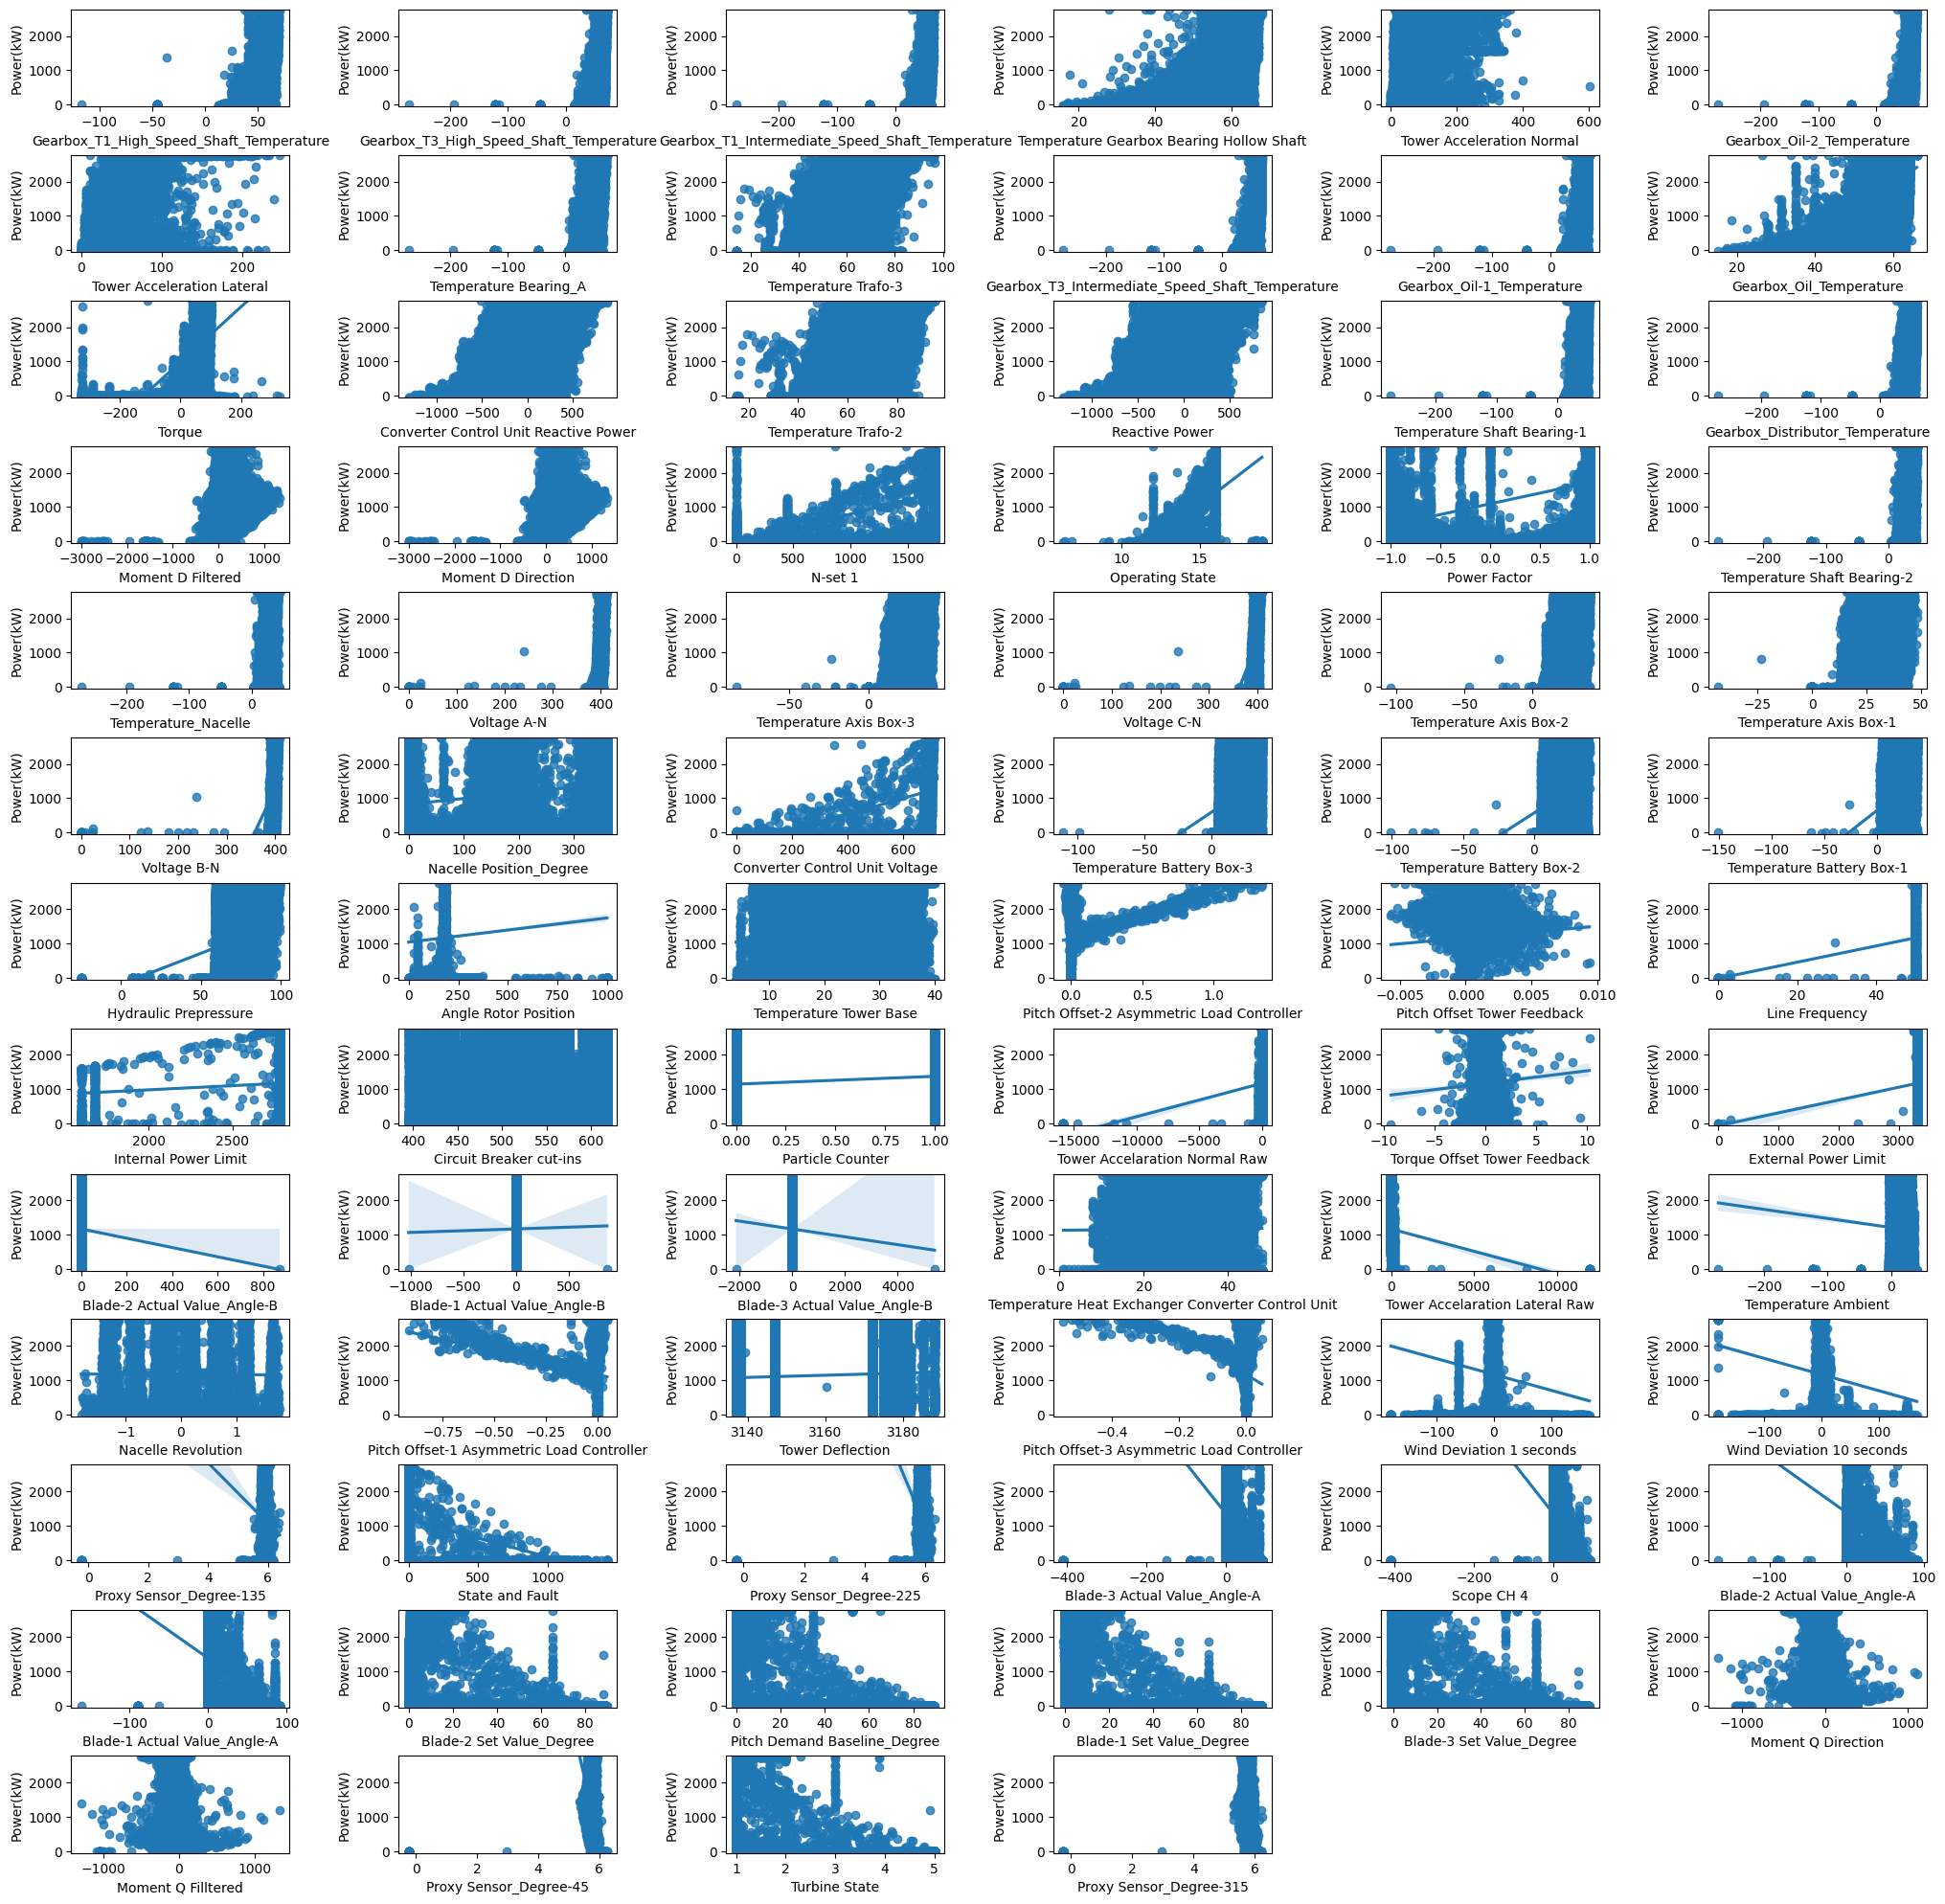

In [39]:
# find min and max bounds for Y-axis
min_power = train_df["Power(kW)"].min()
max_power = train_df["Power(kW)"].max()

# init plot representation
fig, axes = plt.subplots(13, 6, figsize = (25, 25))
axes = axes.ravel()

# draw scatter plot in each subplot
for (i, column) in enumerate(
    column for column in train_df if column != "Power(kW)"
):
    sns.regplot(
        x = column, 
        y = "Power(kW)", 
        data = train_df, ax = axes[i]
    )
    axes[i].set(ylim=(min_power, max_power))

# hide unused subplots
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

# aligh subplots
plt.subplots_adjust(wspace = 0.5, hspace=0.5)

# draw the final plot
plt.show()

Now we can see clear linear relationship for some features, for example, for **Pitch Offset-2 Asymmetric Load Controller** or for **Pitch Offset-3 Asymmetric Load Controller**. Some features may need to apply PlynomialFeatures, for example **Temperature Gearbox Bearing Hollow Shaf**. Some features does not look to have any correlation at all.

#### 2. Correlation heatmap

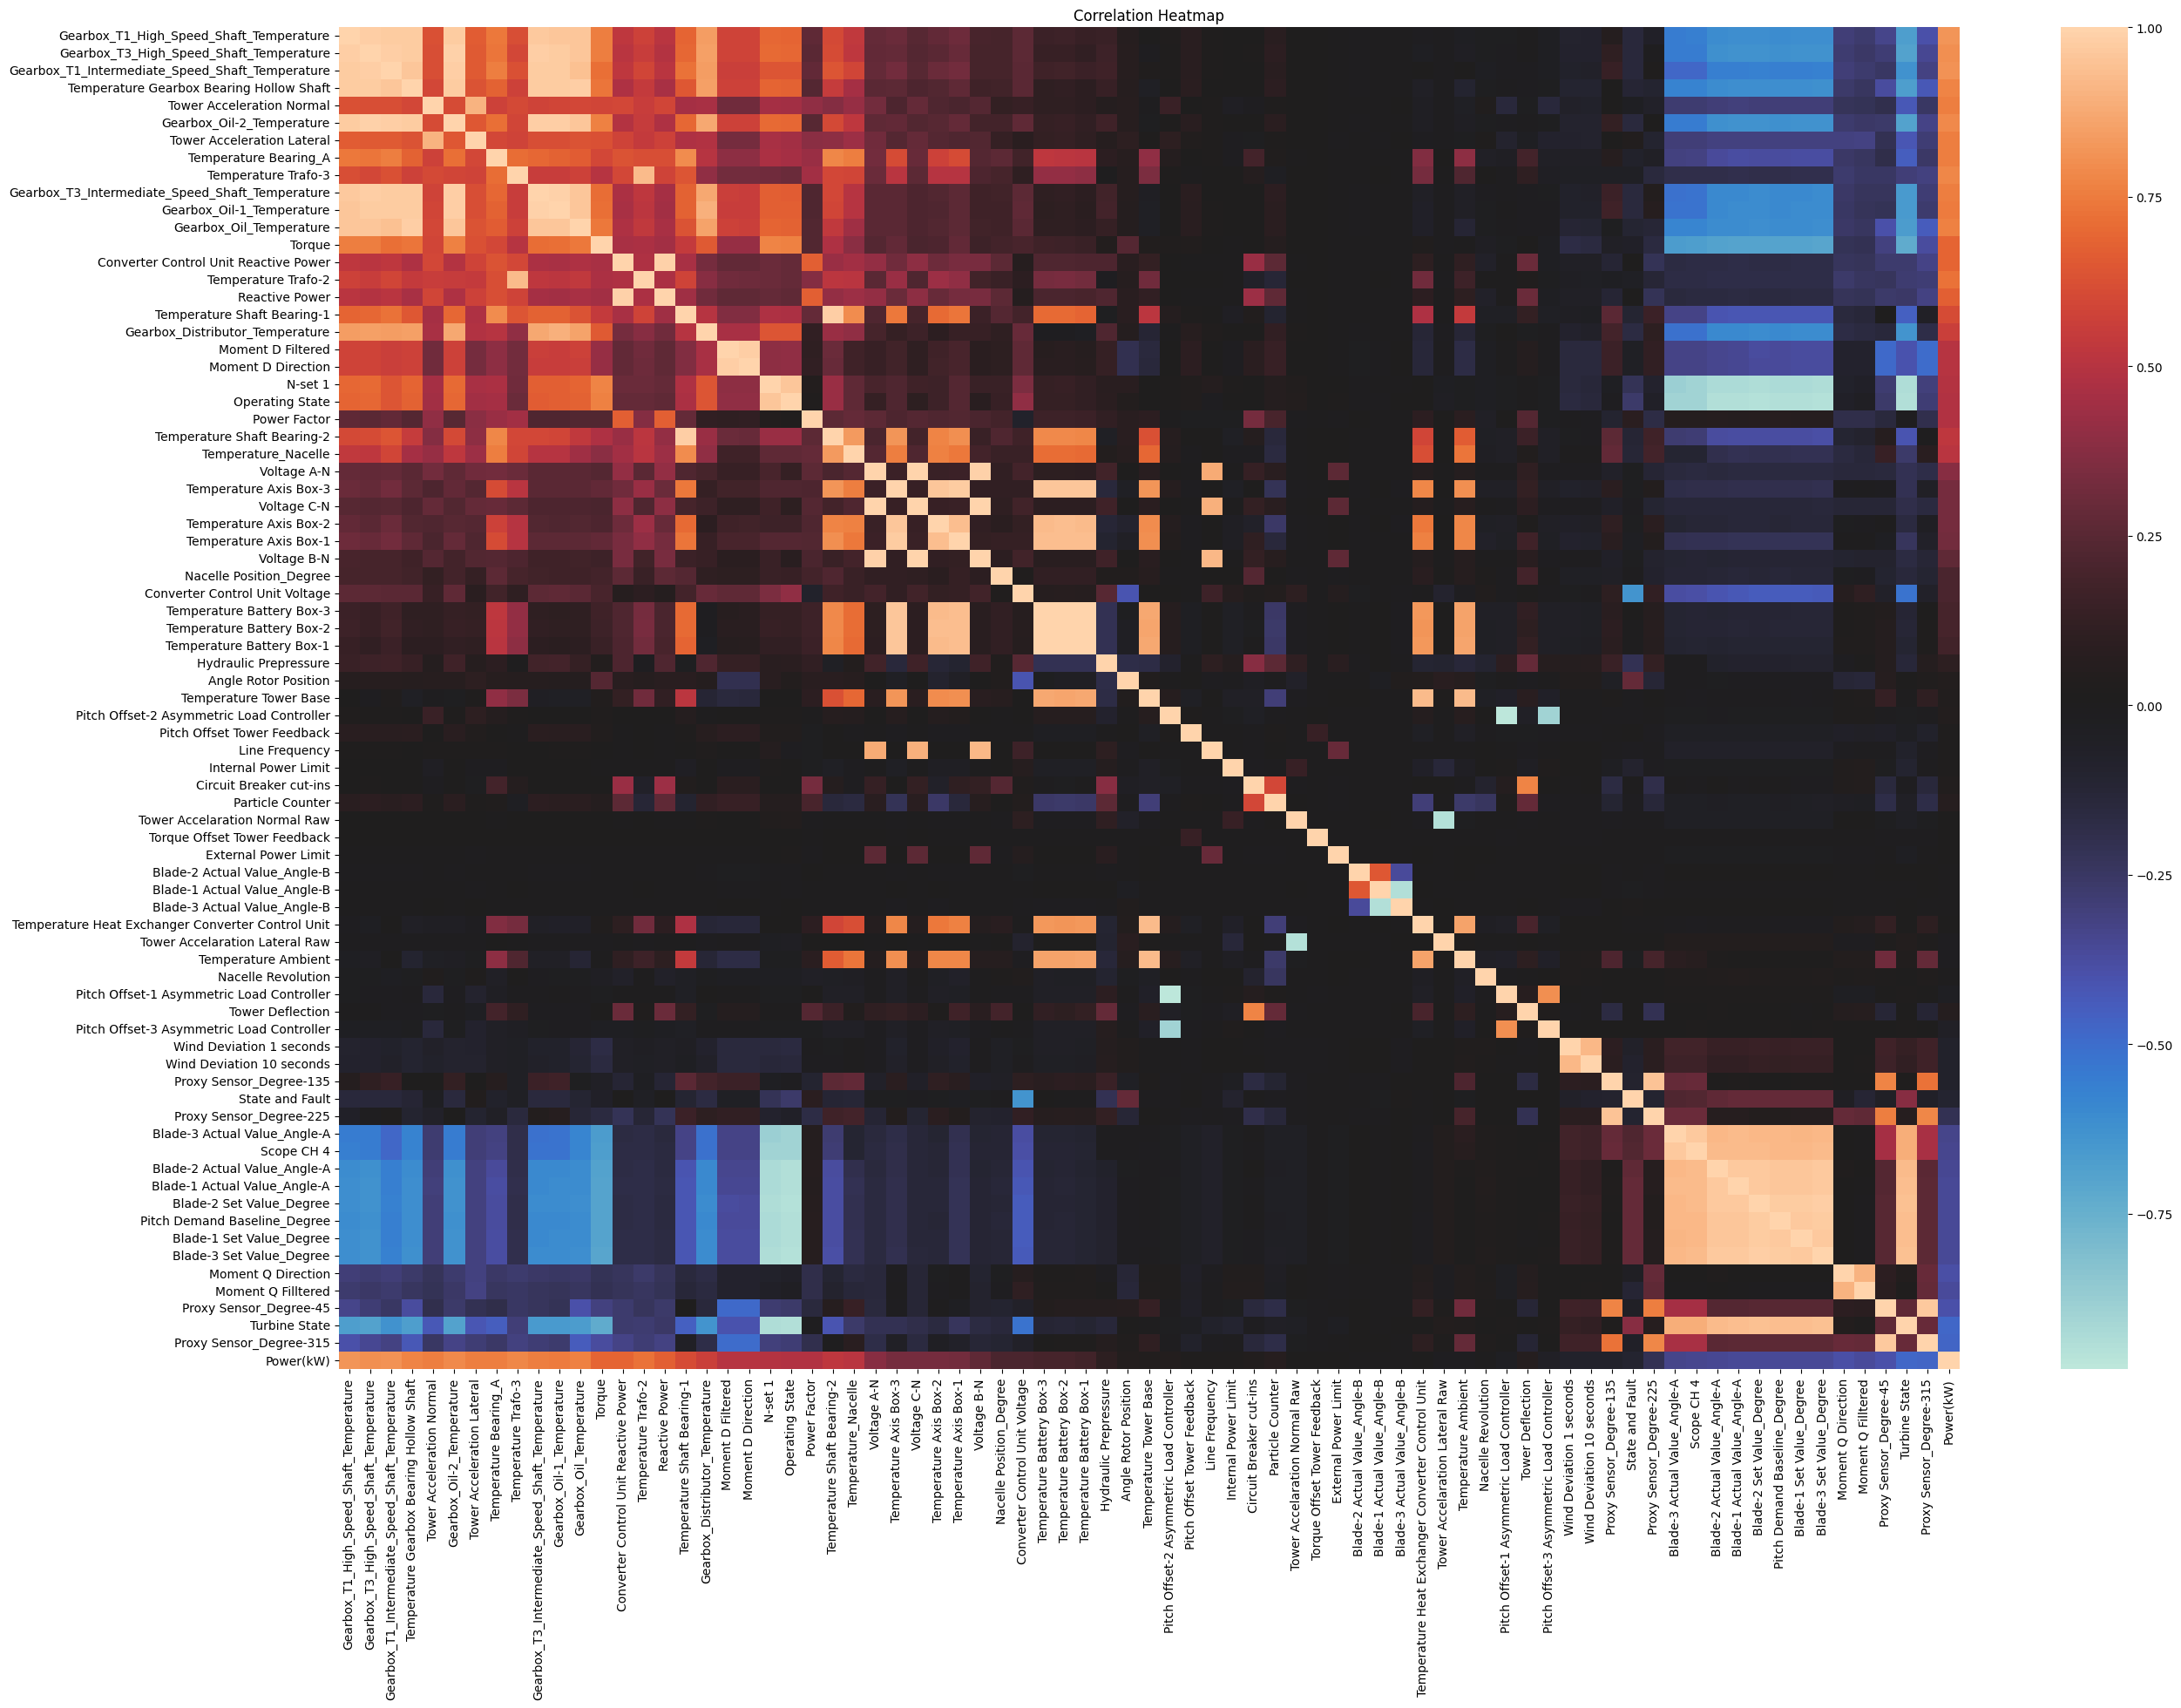

In [40]:
# calculate correlations
correlations = train_df.corr()

# draw heatmap for the correlations
plt.subplots(1,1,figsize=(30,20))
sns.heatmap(correlations, cmap ='icefire')
plt.title('Correlation Heatmap')
plt.show()

Here we are mostly interested in the correlation of all the features with **Power(kW)** column. We can see that about a half of features has positive correlation, and the other half has a correlation about zero or negative. When selecting features, we will need the features with pronounced positive or negative correlation.

#### 3. Distribution density plots paired with Bar plots.
Green line shows how the normal dostribution for the data given would look. Red dashed line shows the mean. Green dashed lines show the confidence interval (from -3Sigma to +3Sigma relatively to the mean).

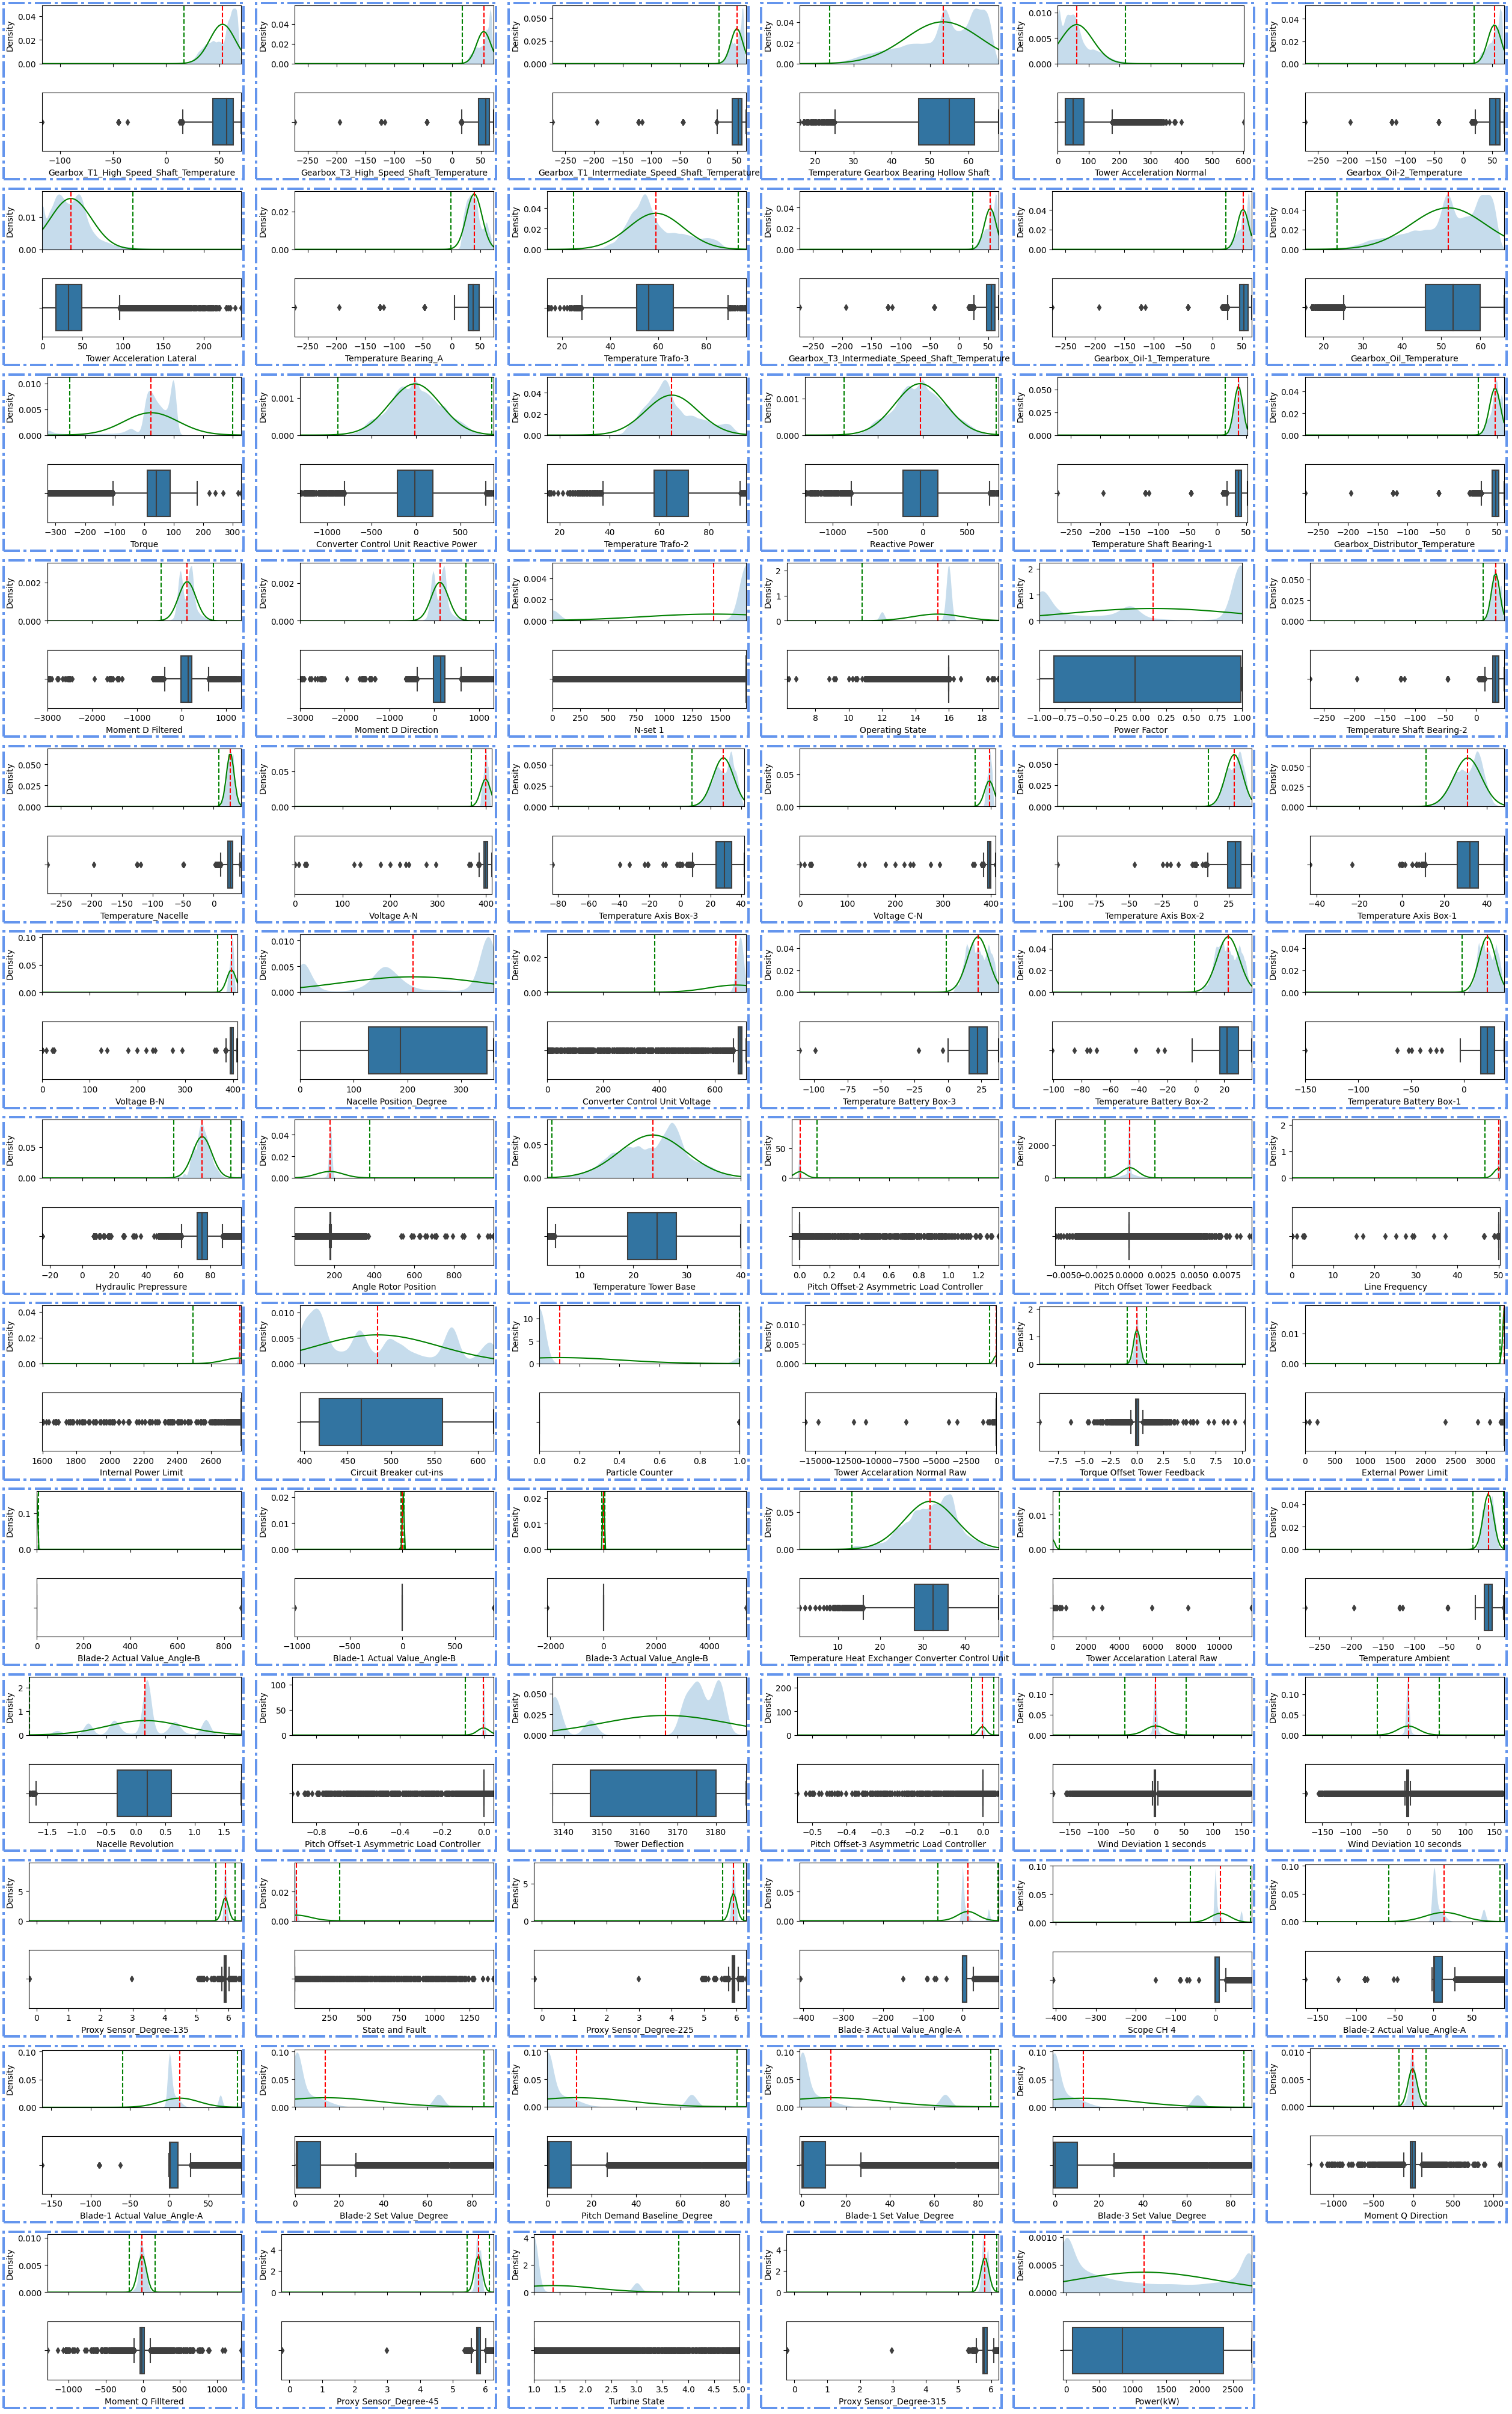

In [41]:
# init the resulting plot representation with subplots
fig = plt.figure(constrained_layout=True, figsize=(25, 40))
subfigures = fig.subfigures(nrows=13, ncols=6, wspace=0.05, hspace=0.05)
subfigures = subfigures.ravel()

# draw a density plot and a bar plot on each subplot
for (i, column) in enumerate(train_df):
    # define suplots for a densinty plot and for a box plot
    density_ax, boxplot_ax = subfigures[i].subplots(
        nrows=2, 
        ncols=1, 
        sharex = True
    )
    
    # define min and max for X-axis
    min_value = train_df[column].min()
    max_value = train_df[column].max()
    
    # set min and max for X-axis
    density_ax.set(xlim=(min_value, max_value))
    boxplot_ax.set(xlim=(min_value, max_value))
    
    # draw density plot
    sns.kdeplot(
        x = column, 
        data = train_df, 
        ax = density_ax, 
        fill = True, 
        linewidth = 0
    )
    
    # draw expected normal distribution (green line)
    exp_mean, exp_std = stats.norm.fit(train_df[column])
    x = np.linspace(min_value, max_value, 100)    
    density_ax.plot(
        x, 
        stats.norm.pdf(x, exp_mean, exp_std),
        color = 'green'
    )
    
    # draw mean and confidence interval (vertical dashed lines)
    mean = train_df[column].mean()
    std = train_df[column].std()
    density_ax.axvline(mean - 3 * std, color='g', linestyle='--')
    density_ax.axvline(mean, color='r', linestyle='--')
    density_ax.axvline(mean + 3 * std, color='g', linestyle='--')
    
    # hide label for upper subplot 
    density_ax.set(xlabel=None)
    
    # draw boxplot
    sns.boxplot(x = train_df[column], ax = boxplot_ax)
    
    # draw blue border
    subfigures[i].patch.set_linestyle('-.')
    subfigures[i].patch.set_linewidth(3)
    subfigures[i].patch.set_edgecolor('cornflowerblue')

# draw the final plot
plt.show()

These plots are quite useful to get more detailed view on distribution and decide about approach for determining outliers.

In the next sections we use all of the plots above to select the best features, make decision about normalization and remove outliers.

### 6-7-8). Build your ML model. Consider how the model’s results could be validated using either cross validation or other models/ensembles. Your model would benefit from using feature engineering techniques or polynomial.

Let's check the columns we thought may be categorical.

In [239]:
perhaps_categorical_columns_df = \
    train_df.loc[:, train_df.nunique() < 100]

pd.DataFrame({
    'Column': perhaps_categorical_columns_df.columns, 
    'Unique Values': [perhaps_categorical_columns_df[column].unique() 
                      for column in perhaps_categorical_columns_df],
    'Correlation with Power': [
        perhaps_categorical_columns_df[column].corr(train_df['Power(kW)']) 
        for column in perhaps_categorical_columns_df
    ]
})

Column  \
0              Particle Counter   
1          External Power Limit   
2  Blade-2 Actual Value_Angle-B   
3  Blade-1 Actual Value_Angle-B   
4  Blade-3 Actual Value_Angle-B   
5              Tower Deflection   

                                       Unique Values  Correlation with Power  
0                                         [0.0, 1.0]                0.063211  
1  [3300.0, 3250.41748046875, 2865.5, 0.0, 71.5, ...                0.007530  
2                           [0.0, 872.9195556640625]               -0.003243  
3       [0.0, 863.686767578125, -1020.9796752929688]                0.000375  
4          [0.0, -2116.335205078125, 5388.166015625]               -0.001824  
5  [3138.0, 3137.88818359375, 3137.010009765625, ...                0.049278

If we look at the corrrelation heatmap, we can see they have about zero correlation with the target Power columns. So let's drop them.

In [195]:
test_df = pd.read_pickle('data/preprocessed/test.pickle')

train_df = train_df.drop(columns = perhaps_categorical_columns_df.columns)
test_df = test_df.drop(columns = perhaps_categorical_columns_df.columns)

Now let's process outliers. For that we check the plots from the Visualization section and use the following strategy for each column:
1. If distribution is similar to normal and visually no many outliers outside of IQR*1.5 range in box plot, use 3 sigma confidence intrval (or samples with z-score less than 3).
2. Regardless of distirbution type, if visually there are many outliers outside of IQR range on box plot, don't remove outliers at all, or remove outliers between visual min and max, or use also 3-sigma or 1.5*IQR if they are close to the visual min/max. If number of ouliers is not a small and not a big, see correlation plots and decide if those outliers can impact the target variable.

Each defined bound below is commented with a number of condition above.

In [196]:
def calculateMinus3Sigma(column):
    return train_df[column].mean() - 3 * train_df[column].std()

def calculatePlus3Sigma(column):
    return train_df[column].mean() + 3 * train_df[column].std()

def calculateMinus15Iqr(column):
    return train_df[column].quantile(0.25) \
        - 1.5 * (train_df[column].quantile(0.75) \
        - train_df[column].quantile(0.25))

def calculatePlus15Iqr(column):
    return train_df[column].quantile(0.75) \
        + 1.5 * (train_df[column].quantile(0.75) \
        - train_df[column].quantile(0.25))

outlier_borders_df = pd.DataFrame(
    columns = ['Feature', 'Lower Border', 'Upper Border'],
    data = [
        ['Gearbox_T1_High_Speed_Shaft_Temperature', 
         calculateMinus3Sigma('Gearbox_T1_High_Speed_Shaft_Temperature'),
         calculatePlus3Sigma('Gearbox_T1_High_Speed_Shaft_Temperature')
        ], #1
        ['Gearbox_T3_High_Speed_Shaft_Temperature', 
         calculateMinus3Sigma('Gearbox_T3_High_Speed_Shaft_Temperature'),
         calculatePlus3Sigma('Gearbox_T3_High_Speed_Shaft_Temperature')
        ], #1
        ['Gearbox_T1_Intermediate_Speed_Shaft_Temperature', 
         calculateMinus3Sigma('Gearbox_T1_Intermediate_Speed_Shaft_Temperature'),
         calculatePlus3Sigma('Gearbox_T1_Intermediate_Speed_Shaft_Temperature')
        ], #1
        ['Temperature Gearbox Bearing Hollow Shaft',
         train_df['Temperature Gearbox Bearing Hollow Shaft'].min(),
         train_df['Temperature Gearbox Bearing Hollow Shaft'].max()
        ], #2
        ['Tower Acceleration Normal', 
         train_df['Tower Acceleration Normal'].min(),
         400
        ], #2
        ['Gearbox_Oil-2_Temperature', 
         calculateMinus3Sigma('Gearbox_Oil-2_Temperature'),
         calculatePlus3Sigma('Gearbox_Oil-2_Temperature')
        ], #1
        ['Tower Acceleration Lateral', 
         train_df['Tower Acceleration Lateral'].min(),
         250
        ], #2
        ['Temperature Bearing_A', 
         calculateMinus3Sigma('Temperature Bearing_A'),
         calculatePlus3Sigma('Temperature Bearing_A')
        ], #1
        ['Temperature Trafo-3', 
         train_df['Temperature Trafo-3'].min(),
         train_df['Temperature Trafo-3'].max()
        ], #2
        ['Gearbox_T3_Intermediate_Speed_Shaft_Temperature', 
         calculateMinus3Sigma('Gearbox_T3_Intermediate_Speed_Shaft_Temperature'),
         calculatePlus3Sigma('Gearbox_T3_Intermediate_Speed_Shaft_Temperature')
        ], #1
        ['Gearbox_Oil-1_Temperature', 
         calculateMinus3Sigma('Gearbox_Oil-1_Temperature'),
         calculatePlus3Sigma('Gearbox_Oil-1_Temperature')
        ], #1
        ['Gearbox_Oil_Temperature', 
         train_df['Gearbox_Oil_Temperature'].min(),
         train_df['Gearbox_Oil_Temperature'].max()
        ], #2
        ['Torque', 
         train_df['Torque'].min(),
         calculatePlus15Iqr('Torque')
        ], #2
        ['Converter Control Unit Reactive Power', 
         train_df['Converter Control Unit Reactive Power'].min(),
         calculatePlus3Sigma('Converter Control Unit Reactive Power')
        ], #2
        ['Temperature Trafo-2', 
         train_df['Temperature Trafo-2'].min(),
         train_df['Temperature Trafo-2'].max()
        ], #2
        ['Reactive Power', 
         train_df['Reactive Power'].min(),
         calculatePlus3Sigma('Reactive Power')
        ], #2
        ['Temperature Shaft Bearing-1', 
         calculateMinus3Sigma('Temperature Shaft Bearing-1'),
         calculatePlus3Sigma('Temperature Shaft Bearing-1')
        ], #1
        ['Gearbox_Distributor_Temperature', 
         0,
         train_df['Gearbox_Distributor_Temperature'].max()
        ], #2
        ['Moment D Filtered', 
         train_df['Moment D Filtered'].min(),
         train_df['Moment D Filtered'].max()
        ], #2
        ['Moment D Direction', 
         train_df['Moment D Direction'].min(),
         train_df['Moment D Direction'].max()
        ], #2
        ['N-set 1', 
         train_df['N-set 1'].min(),
         train_df['N-set 1'].max()
        ], #2
        ['Operating State',
         train_df['Operating State'].min(),
         train_df['Operating State'].max()
        ], #2
        ['Power Factor',
         train_df['Power Factor'].min(),
         train_df['Power Factor'].max()
        ], #2
        ['Temperature Shaft Bearing-2',
         calculateMinus3Sigma('Temperature Shaft Bearing-2'),
         calculatePlus3Sigma('Temperature Shaft Bearing-2')
        ], #1
        ['Temperature_Nacelle',
         calculateMinus3Sigma('Temperature_Nacelle'),
         calculatePlus3Sigma('Temperature_Nacelle')
        ], #1
        ['Voltage A-N',
         train_df['Voltage A-N'].min(),
         train_df['Voltage A-N'].max()
        ], #2
        ['Temperature Axis Box-3',
         -40,
         train_df['Temperature Axis Box-3'].max()
        ], #2
        ['Voltage C-N',
         train_df['Voltage C-N'].min(),
         train_df['Voltage C-N'].max()
        ], #2
        ['Temperature Axis Box-2',
         -25,
         train_df['Temperature Axis Box-2'].max()
        ], #2
        ['Temperature Axis Box-1',
         0,
         train_df['Temperature Axis Box-1'].max()
        ], #2
        ['Voltage B-N',
         train_df['Voltage B-N'].min(),
         train_df['Voltage B-N'].max()
        ], #2
        ['Nacelle Position_Degree',
         train_df['Nacelle Position_Degree'].min(),
         train_df['Nacelle Position_Degree'].max()
        ], #2
        ['Converter Control Unit Voltage',
         train_df['Converter Control Unit Voltage'].min(),
         train_df['Converter Control Unit Voltage'].max()
        ], #2
        ['Temperature Battery Box-3',
         calculateMinus3Sigma('Temperature Battery Box-3'),
         calculatePlus3Sigma('Temperature Battery Box-3')
        ], #1
        ['Temperature Battery Box-2',
         calculateMinus3Sigma('Temperature Battery Box-3'),
         calculatePlus3Sigma('Temperature Battery Box-3')
        ], #1
        ['Temperature Battery Box-1',
         calculateMinus3Sigma('Temperature Battery Box-3'),
         calculatePlus3Sigma('Temperature Battery Box-3')
        ], #1
        ['Hydraulic Prepressure',
         0,
         train_df['Hydraulic Prepressure'].max()
        ], #2
        ['Angle Rotor Position',
         calculateMinus3Sigma('Angle Rotor Position'),
         calculatePlus3Sigma('Angle Rotor Position')
        ], #1
        ['Temperature Tower Base',
         train_df['Temperature Tower Base'].min(),
         train_df['Temperature Tower Base'].max()
        ], #2
        ['Pitch Offset-2 Asymmetric Load Controller',
         train_df['Pitch Offset-2 Asymmetric Load Controller'].min(),
         train_df['Pitch Offset-2 Asymmetric Load Controller'].max()
        ], #2
        ['Pitch Offset Tower Feedback', 
         -0.007,
         train_df['Pitch Offset Tower Feedback'].max()
        ], #2
        ['Line Frequency',
         calculateMinus3Sigma('Line Frequency'),
         calculatePlus3Sigma('Line Frequency')
        ], #1
        ['Internal Power Limit',
         train_df['Internal Power Limit'].min(),
         train_df['Internal Power Limit'].max()
        ], #2
        ['Circuit Breaker cut-ins',
         train_df['Circuit Breaker cut-ins'].min(),
         train_df['Circuit Breaker cut-ins'].max()
        ], #2
        ['Tower Accelaration Normal Raw',
         calculateMinus3Sigma('Tower Accelaration Normal Raw'),
         calculatePlus3Sigma('Tower Accelaration Normal Raw')
        ], #1
        ['Torque Offset Tower Feedback',
         -6.5,
         9
        ], #2
        ['Temperature Heat Exchanger Converter Control Unit',
         train_df['Temperature Heat Exchanger Converter Control Unit'].min(),
         train_df['Temperature Heat Exchanger Converter Control Unit'].max()
        ], #2
        ['Tower Accelaration Lateral Raw',
         calculateMinus3Sigma('Tower Accelaration Lateral Raw'),
         calculatePlus3Sigma('Tower Accelaration Lateral Raw')
        ], #1
        ['Temperature Ambient',
         calculateMinus3Sigma('Temperature Ambient'),
         calculatePlus3Sigma('Temperature Ambient')
        ], #1
        ['Nacelle Revolution',
         train_df['Nacelle Revolution'].min(),
         train_df['Nacelle Revolution'].max()
        ], #2
        ['Pitch Offset-1 Asymmetric Load Controller',
         train_df['Pitch Offset-1 Asymmetric Load Controller'].min(),
         train_df['Pitch Offset-1 Asymmetric Load Controller'].max()
        ], #2
        ['Pitch Offset-3 Asymmetric Load Controller',
         train_df['Pitch Offset-3 Asymmetric Load Controller'].min(),
         train_df['Pitch Offset-3 Asymmetric Load Controller'].max()
        ], #2
        ['Wind Deviation 1 seconds',
         train_df['Wind Deviation 1 seconds'].min(),
         train_df['Wind Deviation 1 seconds'].max()
        ], #2
        ['Wind Deviation 10 seconds',
         train_df['Wind Deviation 10 seconds'].min(),
         train_df['Wind Deviation 10 seconds'].max()
        ], #2
        ['Proxy Sensor_Degree-135',
         -5,
         train_df['Proxy Sensor_Degree-135'].max()
        ], #2
        ['State and Fault',
         train_df['State and Fault'].min(),
         train_df['State and Fault'].max()
        ], #2
        ['Proxy Sensor_Degree-225',
         -5,
         train_df['Proxy Sensor_Degree-225'].max()
        ], #2
        ['Blade-3 Actual Value_Angle-A',
         -100,
         train_df['Blade-3 Actual Value_Angle-A'].max()
        ], #2
        ['Scope CH 4',
         -100,
         train_df['Scope CH 4'].max()
        ], #2
        ['Blade-2 Actual Value_Angle-A', 
         calculateMinus15Iqr('Blade-2 Actual Value_Angle-A'),
         train_df['Blade-2 Actual Value_Angle-A'].max()
        ], #2
        ['Blade-1 Actual Value_Angle-A',
         calculateMinus15Iqr('Blade-1 Actual Value_Angle-A'),
         train_df['Blade-1 Actual Value_Angle-A'].max()
        ], #2
        ['Blade-2 Set Value_Degree',
         train_df['Blade-2 Set Value_Degree'].min(),
         train_df['Blade-2 Set Value_Degree'].max()
        ], #2
        ['Pitch Demand Baseline_Degree',
         train_df['Pitch Demand Baseline_Degree'].min(),
         train_df['Pitch Demand Baseline_Degree'].max()
        ], #2
        ['Blade-1 Set Value_Degree',
         train_df['Blade-1 Set Value_Degree'].min(),
         train_df['Blade-1 Set Value_Degree'].max()
        ], #2
        ['Blade-3 Set Value_Degree',
         train_df['Blade-3 Set Value_Degree'].min(),
         train_df['Blade-3 Set Value_Degree'].max()
        ], #2
        ['Moment Q Direction',
         train_df['Moment Q Direction'].min(),
         train_df['Moment Q Direction'].max()
        ], #2
        ['Moment Q Filltered',
         train_df['Moment Q Filltered'].min(),
         train_df['Moment Q Filltered'].max()
        ], #2
        ['Proxy Sensor_Degree-45',
         calculateMinus3Sigma('Proxy Sensor_Degree-45'),
         calculatePlus3Sigma('Proxy Sensor_Degree-45')
        ], #1
        ['Turbine State',
         train_df['Turbine State'].min(),
         train_df['Turbine State'].max()
        ], #2
        ['Proxy Sensor_Degree-315',
         calculateMinus3Sigma('Proxy Sensor_Degree-315'),
         calculatePlus3Sigma('Proxy Sensor_Degree-315')
        ], #1
        ['Power(kW)',
         train_df['Power(kW)'].min(),
         train_df['Power(kW)'].max()
        ] #2
    ]
)
outlier_borders_df = outlier_borders_df.set_index('Feature')
outlier_borders_df

Lower Border  Upper Border
Feature                                                                      
Gearbox_T1_High_Speed_Shaft_Temperature               16.981356     89.181137
Gearbox_T3_High_Speed_Shaft_Temperature               18.056581     91.826531
Gearbox_T1_Intermediate_Speed_Shaft_Temperature       18.261156     80.658821
Temperature Gearbox Bearing Hollow Shaft              16.000000     67.966667
Tower Acceleration Normal                              0.000000    400.000000
Gearbox_Oil-2_Temperature                             18.900880     88.093215
Tower Acceleration Lateral                             0.000000    250.000000
Temperature Bearing_A                                 -1.454599     79.892136
Temperature Trafo-3                                   13.845000     96.476669
Gearbox_T3_Intermediate_Speed_Shaft_Temperature       23.177747     83.652679
Gearbox_Oil-1_Temperature                             22.504714     81.017080
Gearbox_Oil_Temperature                               15.294294     66.000000
Torque                                              -327.679993    202.658343
Converter Control Unit Reactive Power              -1303.373291    857.514348
Temperature Trafo-2                                   15.000000     95.000000
Reactive Power                                     -1307.984985    820.519412
Temperature Shaft Bearing-1                           14.528403     59.191739
Gearbox_Distributor_Temperature                        0.000000     62.299999
Moment D Filtered                                  -3001.270264   1331.326904
Moment D Direction                                 -3001.361572   1327.589111
N-set 1                                                0.000000   1735.021484
Operating State                                        6.290000     19.000000
Power Factor                                          -1.000000      1.000000
Temperature Shaft Bearing-2                           11.459419     52.959024
Temperature_Nacelle                                    8.588903     46.151740
Voltage A-N                                            0.000000    413.083344
Temperature Axis Box-3                               -40.000000     42.000000
Voltage C-N                                            0.000000    410.140015
Temperature Axis Box-2                               -25.000000     42.000000
Temperature Axis Box-1                                 0.000000     48.000000
Voltage B-N                                            0.000000    409.003326
Nacelle Position_Degree                                0.000000    359.998322
Converter Control Unit Voltage                         0.000000    712.169983
Temperature Battery Box-3                             -1.278393     46.163343
Temperature Battery Box-2                             -1.278393     46.163343
Temperature Battery Box-1                             -1.278393     46.163343
Hydraulic Prepressure                                  0.000000     99.230820
Angle Rotor Position                                 -23.131326    377.902126
Temperature Tower Base                                 4.000000     40.000000
Pitch Offset-2 Asymmetric Load Controller             -0.051858      1.338862
Pitch Offset Tower Feedback                           -0.007000      0.009408
Line Frequency                                        46.601545     53.331430
Internal Power Limit                                1597.832520   2780.000000
Circuit Breaker cut-ins                              395.000000    618.000000
Tower Accelaration Normal Raw                       -554.364173    552.443800
Torque Offset Tower Feedback                          -6.500000      9.000000
Temperature Heat Exchanger Converter Control Unit      1.000000     48.000000
Tower Accelaration Lateral Raw                      -397.018869    397.095898
Temperature Ambient                                   -8.339402     40.393037
Nacelle Revolution                                    -1.811111      1.78

Let's remove rows with outliers from the train dataset using bounds defined above.

In [197]:
# remove all samples where at least one column does not fit to the lowe-upper bound
train_df = train_df[train_df.apply(
    lambda row: \
        all(row[column] <= outlier_borders_df.loc[column]['Upper Border'] \
        and row[column] >= outlier_borders_df.loc[column]['Lower Border'] 
            for column in train_df.columns), 
    axis=1
)]

For the test dataset we can not just remove unwanted samples, we should predict them. But we can fit outliers from the test dataset to the min and max possible values from the train dataset.

That fitting is legal because it can be included in the resulting pipeline as a prediction preprocessing step. Also it allows us to normalize only the features but not the target variable. Because otherwise even a small outlier of a feature in the test dataset could have a huge impact on the predicted target variable and we recieve quite an outlying prediction result.

In [198]:
# function that mutates each row by fitting column values to the lower/upper bound
def fitMinMax(row):
    for column in test_df.columns:
        if row[column] > train_df[column].max():
            row[column] = train_df[column].max()
        elif row[column] < train_df[column].min():
            row[column] = train_df[column].min()
    return row
            
# apply mutation
test_df.apply(fitMinMax, axis=1)

Gearbox_T1_High_Speed_Shaft_Temperature  \
112782                                62.578335   
112783                                60.845001   
112784                                59.578335   
112785                                59.000000   
112786                                59.044998   
...                                         ...   
136725                                61.000000   
136726                                61.000000   
136727                                61.000000   
136728                                61.000000   
136729                                61.000000   

        Gearbox_T3_High_Speed_Shaft_Temperature  \
112782                                65.983330   
112783                                64.389999   
112784                                63.264999   
112785                                62.000000   
112786                                62.000000   
...                                         ...   
136725                                63.000000   
136726                                62.393333   
136727                                62.000000   
136728                                62.000000   
136729                                62.000000   

        Gearbox_T1_Intermediate_Speed_Shaft_Temperature  \
112782                                        58.848331   
112783                                        57.439999   
112784                                        56.145000   
112785                                        55.000000   
112786                                        54.794998   
...                                                 ...   
136725                                        56.041668   
136726                                        56.000000   
136727                                        56.000000   
136728                                        56.000000   
136729                                        56.000000   

        Temperature Gearbox Bearing Hollow Shaft  Tower Acceleration Normal  \
112782                                 62.981667                  54.795925   
112783                                 61.290001                  49.589661   
112784                                 59.958332                  42.969105   
112785                                 59.000000                  43.936073   
112786                                 58.196667                  42.008018   
...                                          ...                        ...   
136725                                 58.000000                 153.287247   
136726                                 58.000000                 155.118393   
136727                                 58.000000                 156.138977   
136728                                 58.000000                 143.470795   
136729                                 58.000000                 148.219223   

        Gearbox_Oil-2_Temperature  Tower Acceleration Lateral  \
112782                  63.154999                   23.623352   
112783                  61.738335                   31.783428   
112784                  60.466667                   33.009418   
112785                  60.000000                   27.973635   
112786                  59.608334                   30.596987   
...                           ...                         ...   
136725                  60.000000                   69.762711   
136726                  60.000000                   82.937195   
136727                  60.000000                   74.502060   
136728                  60.000000                   81.649567   
136729                  60.000000                   68.003006   

        Temperature Bearing_A  Temperature Trafo-3  \
112782              41.446667            63.086666   
112783              40.018333            60.623333   
112784              39.436668            58.373333   
112785              38.098331            56.430000   
112786              38.000000            54.816666   
...                

At the current moment we saw that:
1. There are features we want to try to process using PolynomialFeatures.
2. All the features have significantly different ranges.

If we use PolynomialFeatures, the different ranges of the features may hinder to achieve a good results. So let's normalize our features.

In [199]:
scaler = MinMaxScaler()
scaler.fit(train_df.loc[:, train_df.columns != 'Power(kW)'])

train_df.loc[:, train_df.columns != 'Power(kW)'] = \
    scaler.transform(train_df.loc[:, train_df.columns != 'Power(kW)'])
test_df.loc[:, test_df.columns != 'Power(kW)'] = \
    scaler.transform(test_df.loc[:, test_df.columns != 'Power(kW)'])

And save the processed datasets for later usage.

In [200]:
train_df.to_pickle('data/normalized/train.pickle')
test_df.to_pickle('data/normalized/test.pickle')

Let's see how a scatter plots on the cleaned and normalized features look.

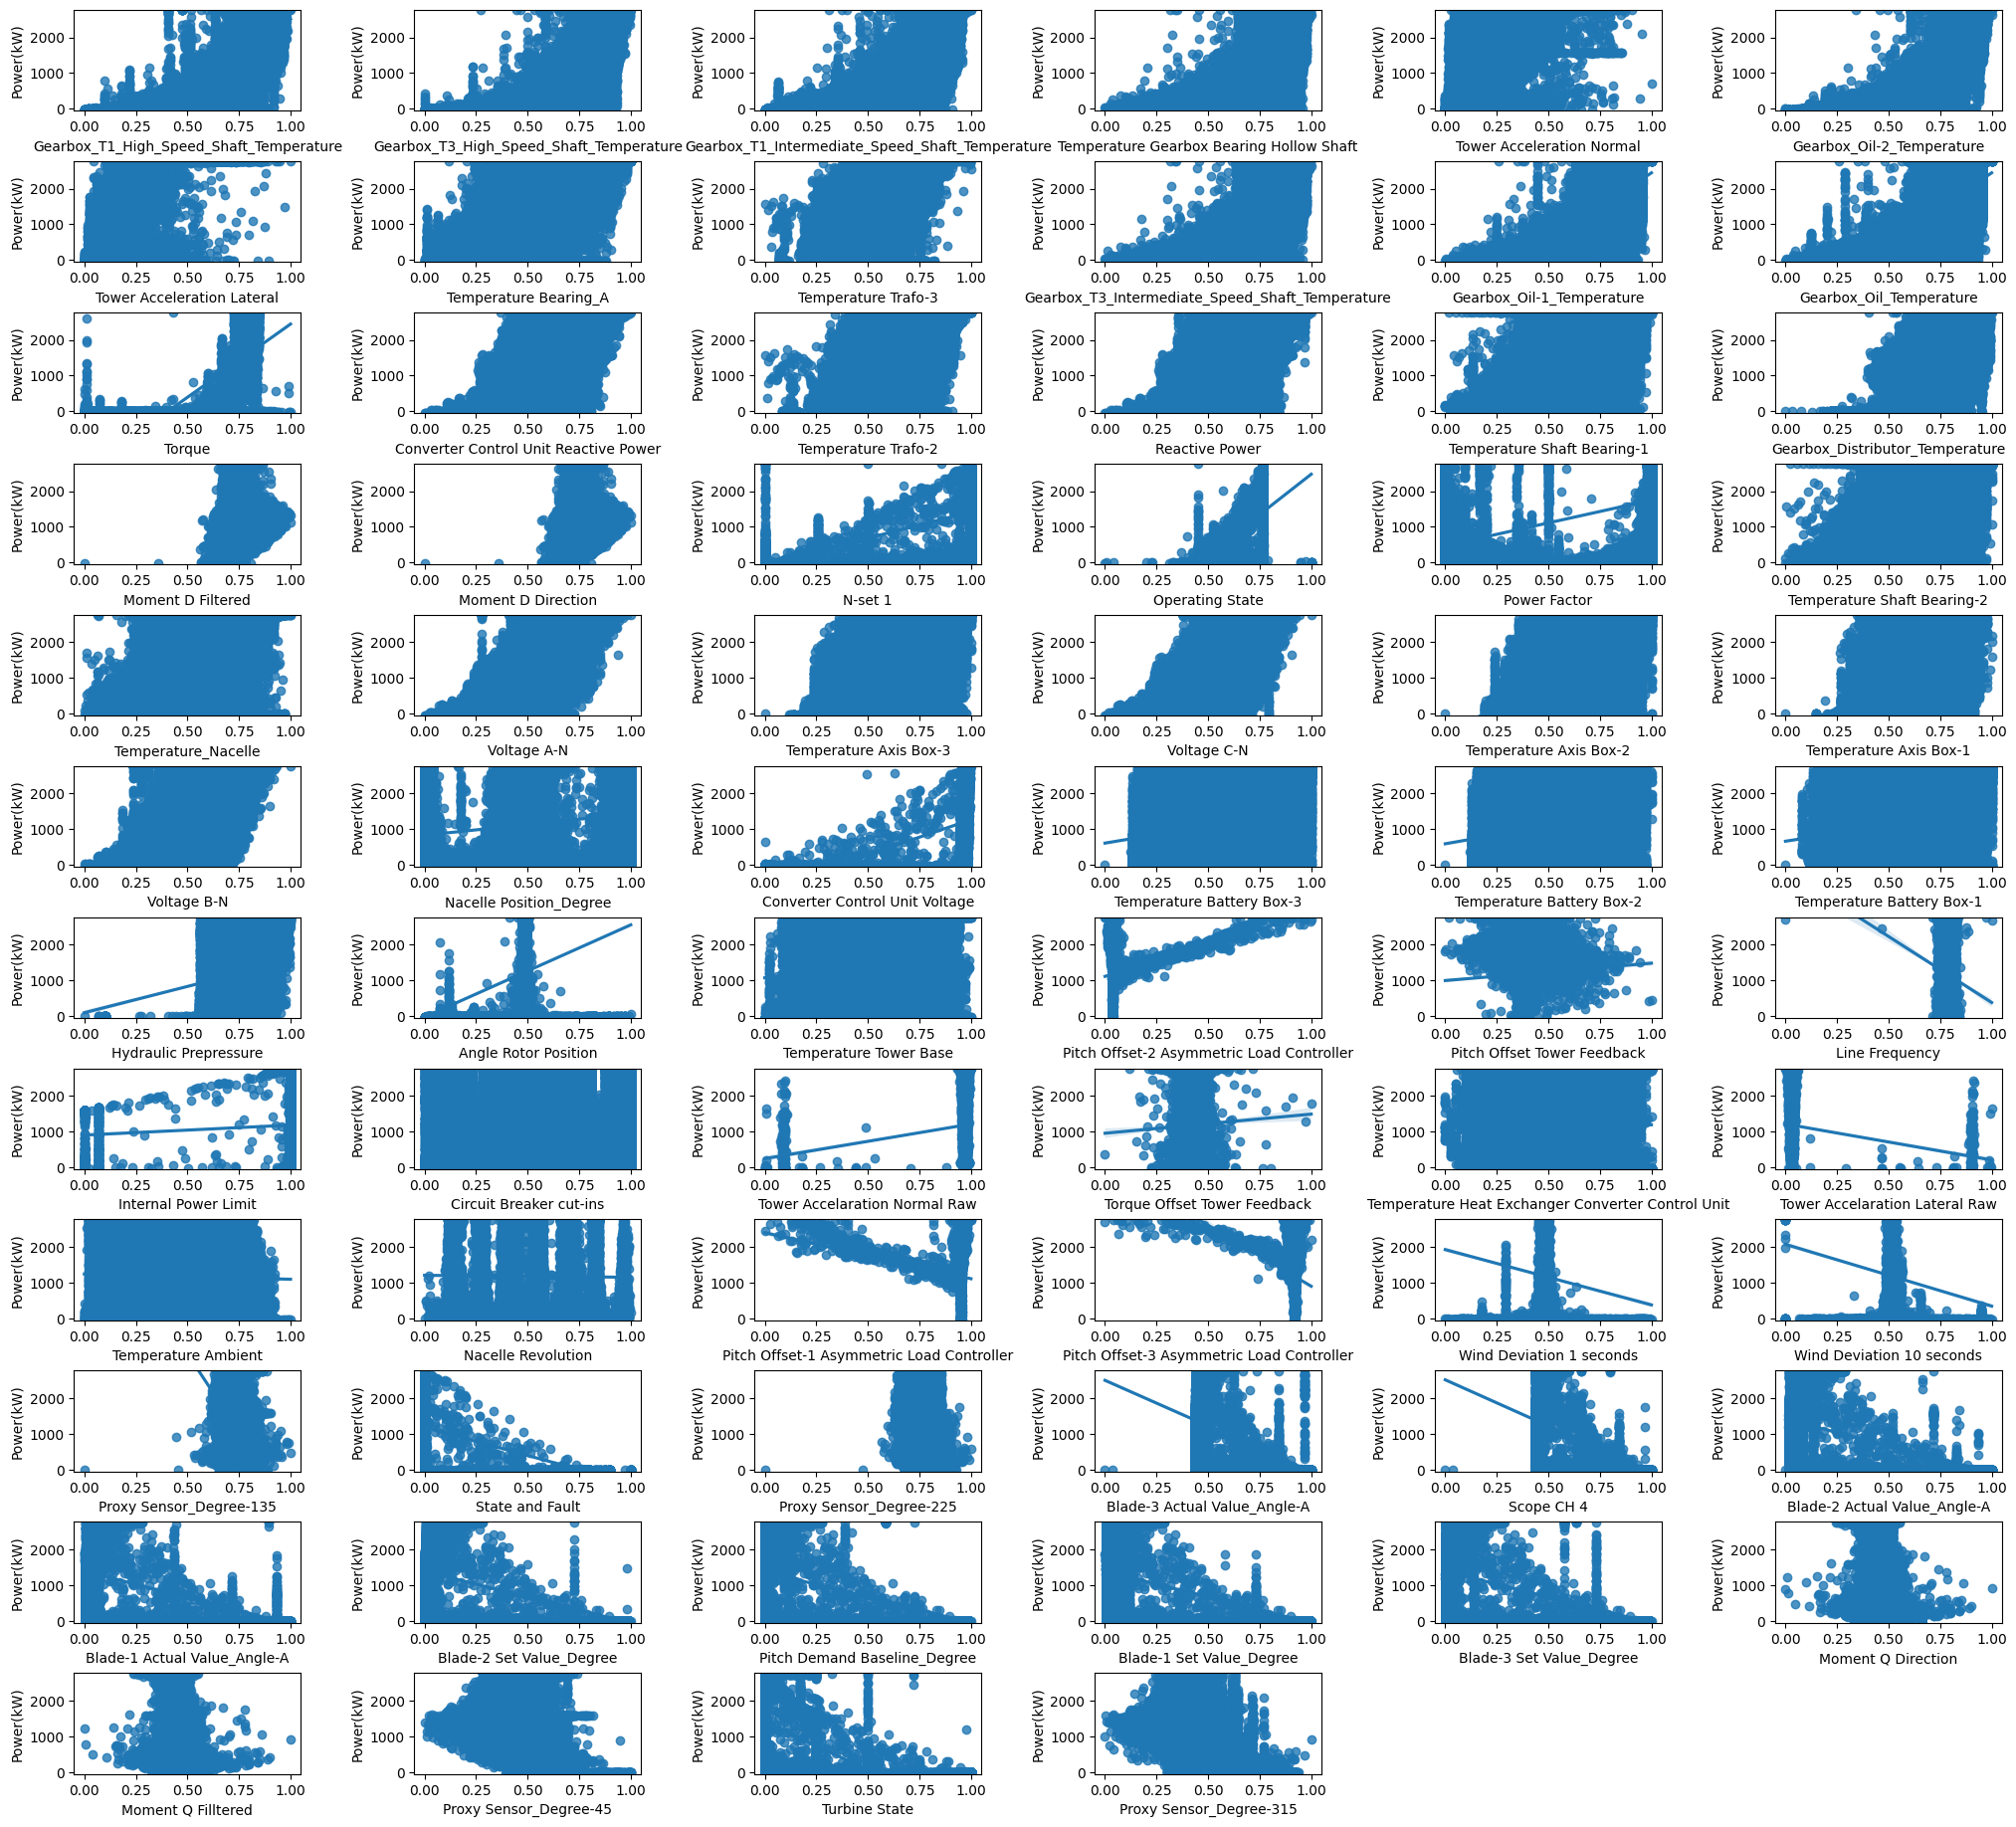

In [201]:
# reread the train dataset
train_df = pd.read_pickle('data/normalized/train.pickle')

# define min and max for Y-axis
min_power = train_df["Power(kW)"].min()
max_power = train_df["Power(kW)"].max()

# init the plots representation
fig, axes = plt.subplots(13, 6, figsize = (25, 25))
axes = axes.ravel()

# draw individual scatter plots
for (i, column) in enumerate(
    column for column in train_df if column != "Power(kW)"
):
    sns.regplot(
        x = column, 
        y = "Power(kW)", 
        data = train_df, ax = axes[i]
    )
    axes[i].set(ylim=(min_power, max_power))

# drop unused subplots
for i in range(2 + perhaps_categorical_columns_df.columns.shape[0]):
    fig.delaxes(axes[-(i + 1)])

# aligh subplots
plt.subplots_adjust(wspace = 0.5, hspace=0.5)

# draw final plot
plt.show()

The next step is to select the most meaningful features from the dataset and learn the model. We will try several approaches with Pipeline and K-fold Cross Validation using GridSearchCV.

In this sklearn transformer we just manually select the features with best correlation using the Correlation Heatmap.

In [202]:
class ManualCorrelationFeatureSelector(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[
            'Gearbox_T1_High_Speed_Shaft_Temperature', 
            'Gearbox_T3_High_Speed_Shaft_Temperature',
            'Gearbox_T1_Intermediate_Speed_Shaft_Temperature',
            'Temperature Gearbox Bearing Hollow Shaft', 
            'Tower Acceleration Normal',
            'Gearbox_Oil-2_Temperature', 
            'Tower Acceleration Lateral',
            'Temperature Bearing_A', 
            'Temperature Trafo-3',
            'Gearbox_T3_Intermediate_Speed_Shaft_Temperature',
            'Gearbox_Oil-1_Temperature', 
            'Gearbox_Oil_Temperature', 'Torque',
            'Converter Control Unit Reactive Power', 
            'Temperature Trafo-2',
            'Reactive Power', 
            'Temperature Shaft Bearing-1',
            'Gearbox_Distributor_Temperature', 
            'Moment D Filtered',
            'Moment D Direction', 
            'N-set 1', 
            'Operating State', 
            'Power Factor',
            'Temperature Shaft Bearing-2', 
            'Temperature_Nacelle', 
            'Voltage A-N',
            'Blade-3 Actual Value_Angle-A', 
            'Scope CH 4',
            'Blade-2 Actual Value_Angle-A', 
            'Blade-1 Actual Value_Angle-A',
            'Blade-2 Set Value_Degree', 
            'Pitch Demand Baseline_Degree',
            'Blade-1 Set Value_Degree', 
            'Blade-3 Set Value_Degree',
            'Moment Q Direction',
            'Moment Q Filltered', 
            'Proxy Sensor_Degree-45',
            'Turbine State', 
            'Proxy Sensor_Degree-315'
        ]]

And in this sklearn transformer we manually select the best features that have a clear linear or a polynomial relationship using the Scatter Plots.

In [203]:
class ManualScatterPlotFeatureSelector(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[
            'Gearbox_T1_High_Speed_Shaft_Temperature',
            'Gearbox_T3_High_Speed_Shaft_Temperature',
            'Gearbox_T1_Intermediate_Speed_Shaft_Temperature',
            'Temperature Gearbox Bearing Hollow Shaft', 
            'Gearbox_Oil-2_Temperature', 
            'Gearbox_T3_Intermediate_Speed_Shaft_Temperature',
            'Converter Control Unit Reactive Power', 
            'Reactive Power', 
            'N-set 1', 
            'Operating State', 
            'Power Factor',
            'Voltage A-N',
            'Voltage C-N', 
            'Converter Control Unit Voltage', 
            'Pitch Offset-2 Asymmetric Load Controller',
            'Pitch Offset-1 Asymmetric Load Controller',
            'Pitch Offset-3 Asymmetric Load Controller', 
            'State and Fault',
            'Blade-2 Actual Value_Angle-A', 
            'Blade-1 Actual Value_Angle-A',
            'Blade-2 Set Value_Degree',
            'Pitch Demand Baseline_Degree',
            'Blade-1 Set Value_Degree', 
            'Blade-3 Set Value_Degree',
            'Turbine State'
        ]]

This sklearn transformer applies PolynomialFeatures only to manually selected features that seem to have polynomial relationship, and leaves other features as is.

In [204]:
class SelectivePolynomialFeatures(PolynomialFeatures):
    def __init__(self, degree = 2):
        super().__init__(degree = degree)
        self.columns = [
            'Gearbox_T1_High_Speed_Shaft_Temperature',
            'Gearbox_T3_High_Speed_Shaft_Temperature',
            'Gearbox_T1_Intermediate_Speed_Shaft_Temperature',
            'Temperature Gearbox Bearing Hollow Shaft', 
            'Gearbox_Oil-2_Temperature', 
            'Gearbox_T3_Intermediate_Speed_Shaft_Temperature',
            'Gearbox_Oil-1_Temperature', 
            'Gearbox_Oil_Temperature', 
            'Converter Control Unit Reactive Power',
            'Reactive Power',
            'Power Factor',
            'Blade-3 Actual Value_Angle-A', 
            'Scope CH 4'
        ]
        
    def fit(self, X, y=None):
        present_columns = [column 
                           for column in self.columns if column in X.columns]
        super().fit(X[present_columns])
        return self

    def transform(self, X):
        present_columns = [column 
                           for column in self.columns if column in X.columns]
        transform_result = super().transform(X[present_columns])
        return np.append(
            X.drop(columns = present_columns, errors = 'ignore').to_numpy(), 
            transform_result, 
            axis = 1
        )

Now we build the Pipeline and the Parameters Grid for Cross Validation.

In [205]:
train_df = pd.read_pickle('data/normalized/train.pickle')
test_df = pd.read_pickle('data/normalized/test.pickle')

x_train = train_df.loc[:, train_df.columns != 'Power(kW)']
y_train = train_df['Power(kW)']
x_test = test_df.loc[:, test_df.columns != 'Power(kW)']
y_test = test_df['Power(kW)']

pipeline = Pipeline([
    ('feature_selection', SelectKBest()),
    ('feature_enriching', PolynomialFeatures()),
    ('prediction', LinearRegression())
])

param_grid = [
    {
        'feature_selection': [
            ManualCorrelationFeatureSelector(), 
            ManualScatterPlotFeatureSelector()
        ],
        'feature_enriching': [
            PolynomialFeatures(), 
            SelectivePolynomialFeatures()
        ],
        'feature_enriching__degree': [1, 2],
        'prediction': [LinearRegression()],
        'prediction__fit_intercept': [True, False]
    },
    {
        'feature_selection': [SelectKBest()],
        'feature_selection__score_func' : [
            f_regression, 
            r_regression, 
            mutual_info_regression
        ],
        'feature_selection__k' : [5, 10, 20, 40, 'all'],
        'feature_enriching': [PolynomialFeatures()],
        'feature_enriching__degree': [1, 2],
        'prediction': [LinearRegression()],
        'prediction__fit_intercept': [True, False]
    }
]

grid_search = GridSearchCV(
    pipeline, 
    param_grid,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    refit = False,
    verbose = 1,
    n_jobs = 25
)

Find the best model.

In [206]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 76 candidates, totalling 380 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection', SelectKBest()),
                                       ('feature_enriching',
                                        PolynomialFeatures()),
                                       ('prediction', LinearRegression())]),
             n_jobs=25,
             param_grid=[{'feature_enriching': [PolynomialFeatures(),
                                                SelectivePolynomialFeatures()],
                          'feature_enriching__degree': [1, 2],
                          'feature_selection': [ManualCorrelationFeatureSelector(),
                                                Manua...
                          'feature_selection': [SelectKBest()],
                          'feature_selection__k': [5, 10, 20, 40, 'all'],
                          'feature_selection__score_func': [<function f_regression at 0x7f29d5df7ca0>,
                                                            <function r_regression at 0x7f29d5df7c10>,
                                                            <function mutual_info_regression at 0x7f29d5e0c3a0>],
                          'prediction': [LinearRegression()],
                          'prediction__fit_intercept': [True, False]}],
             refit=False, scoring='neg_mean_squared_error', verbose=1)

Show the hyperparameters for the best model.

In [207]:
grid_search.best_params_

{'feature_enriching': PolynomialFeatures(),
 'feature_enriching__degree': 2,
 'feature_selection': SelectKBest(),
 'feature_selection__k': 20,
 'feature_selection__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True, force_finite=True)>,
 'prediction': LinearRegression(),
 'prediction__fit_intercept': True}

Build and save the final ML-pipeline.

In [208]:
result_pipeline = Pipeline([
    ('feature_selection', SelectKBest(k = 20, score_func = f_regression)),
    ('feature_enriching', PolynomialFeatures(2)),
    ('prediction', LinearRegression(fit_intercept = True))
])
result_pipeline.fit(x_train, y_train)

# save model for later usage if needed
with open('data/models/lin_reg_pipeline.pickle','wb') as file:
    pickle.dump(result_pipeline, file)

In [209]:
y_pred = result_pipeline.predict(x_test)

## III. Conclusions
### 10. Evaluation of the project and its results

For the evaluation of the project we follow the following steps:
1. Build a residual plot to see if there is any tendency in residuals distribution and a density plot for residuals to see how close the residuals are to the normal distribution. That allows us to check if the model is more or less correct and appropriate for the dataset.
2. Calculate the regression metrics:
    1. RMSE - Root Mean Squared Error - The square root of the average of the squared differences between the predicted and the actual values. The less value is better, the high value means we have some number large errors as the metric penalizes large errors. It also can be high due to outliers in the prediction.
    2. MAE - Mean Absolute Error - The average of the absolute differences between the predicted and the actual values. Unlike RMSE it does not penalize large errors but still can be higher when we have outliers.
    3. R-squared - Coefficient of Determination - Represents the part of the variance of the predicted values explained by the independent variables. Can be considered as a measure of the strength of the relationship between the model and the dependent variable. Higher is better, the maximum value is 1, in such case the model represents the variance of the dependent variable. If the metrics is very low (it can be even negative), then the model does not represent the variance of the dependent variable, and probably a wrong approach for building the regression model was chosen.

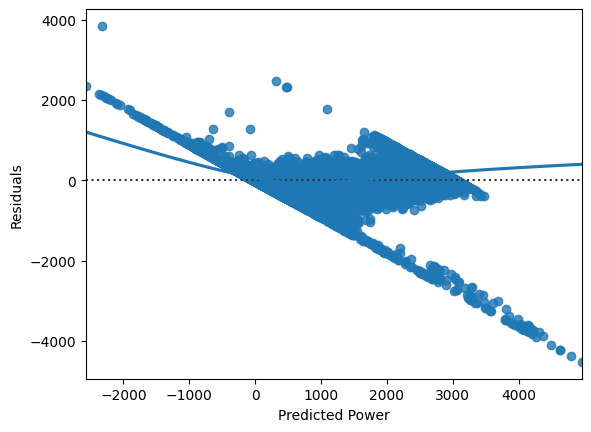

In [235]:
# calculate residuals
residuals = y_test - y_pred

# draw residual plot
sns.residplot(x = y_pred, y = residuals, lowess = True)
plt.xlabel('Predicted Power')
plt.ylabel('Residuals')
plt.show()

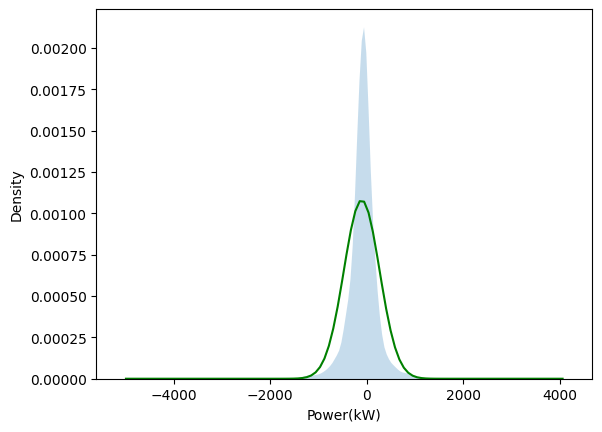

In [231]:
# draw density plot
ax = sns.kdeplot(x = residuals, fill = True, linewidth = 0)

# draw expected normal distribution line
normal_mean, normal_std = stats.norm.fit(residuals)
x = np.linspace(residuals.min(), residuals.max(), 100)    
ax.plot(x, stats.norm.pdf(x, normal_mean, normal_std), color = 'green')
    
# draw final plot    
plt.show()

Ideally the residuals are expected to be normally distributed around 0. In our case we can see that they a bit shifted to the negative side. Probably that is connected with the fact the we incorrectly modified the test data. But at the sime time we observe that that shift is more typical for outliers and in general the distribution is very similar to the normal. Therefore we conclude that our model is mostly well chosen for the given dataset.

Next we calculate the metrics discussed.

In [236]:
print(f'RMSE - {mean_squared_error(y_test, y_pred, squared = False)}')
print(f'MAE - {mean_absolute_error(y_test, y_pred)}')
print(f'R-squared - {r2_score(y_test, y_pred)}')
print(f'Y Test Range - {y_test.min()} - {y_test.max()}')
print(f'Y Pred Range - {y_pred.min()} - {y_pred.max()}')

RMSE - 383.85781768643096
MAE - 225.89940647123692
R-squared - 0.8623521617783692
Y Test Range - -35.063331604003906 - 2770.45166015625
Y Pred Range - -2570.564212146519 - 4959.27894867423


RMSE is higher than MAE because we have some number of outliers with large errors. But even with outliers mean error is not beyond 10% from the target variable range. R-squared is pretty decent and shows that our model catches most of the dependencies between the features and the target value.

If we remain in the scope of a linear regression, improvements might be a better feature selection that considers the relationships between the features, more advanced outliers processing using some ML-model instead of just manual preprocessing. Also perhpas other not lineal regression models (for example, XGBoost) may provide better scores as they are capable to catch more non-trivial relationships.

The model built is fully functioning and thus the project results are good enough to be applied for the real contribution discussed in the Introduction section.

Other domain-specific areas also can benefit from this project as the approaches and processing steps shown are interoperable with any kind of numeric data we want to apply regression for.

In [250]:

%%html

<!--adjust font size for export to pdf -->
<style>
.dataframe th {
    font-size: 5px;
}
.dataframe td {
    font-size: 4px;
}
</style>